# Imports, Device

In [42]:
!pwd

/home/shatz/adv_deep_learning


In [43]:
%matplotlib inline
#from tqdm import tqdm
from tqdm.notebook import tqdm

import torchvision
import torch
from torch import nn
from torch.nn import functional as F
from torchvision.transforms import transforms
from torchvision.datasets.utils import download_url
import os
import tarfile
import hashlib
import numpy as np
import queue

import matplotlib.pyplot as plt

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [45]:
device

device(type='cuda')

# ⬇️ Download Dataset

Most of this is copied from Tutorial 4

In [46]:
# https://github.com/fastai/imagenette
dataset_url = 'https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz'
dataset_filename = dataset_url.split('/')[-1]
dataset_foldername = dataset_filename.split('.')[0]
data_path = './data'
dataset_filepath = os.path.join(data_path,dataset_filename)
dataset_folderpath = os.path.join(data_path,dataset_foldername)

os.makedirs(data_path, exist_ok=True)

download = False
if not os.path.exists(dataset_filepath):
    download = True
else:
    md5_hash = hashlib.md5()


    file = open(dataset_filepath, "rb")

    content = file.read()

    md5_hash.update(content)


    digest = md5_hash.hexdigest()
    if digest != 'fe2fc210e6bb7c5664d602c3cd71e612':
        download = True
if download:
    download_url(dataset_url, data_path)

with tarfile.open(dataset_filepath, 'r:gz') as tar:
    tar.extractall(path=data_path)

  0%|          | 0/1557161267 [00:00<?, ?it/s]

In [6]:
class TwoCropsTransform:
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform):
        self.base_transform = base_transform

    def __call__(self, x):
        q = self.base_transform(x)
        k = self.base_transform(x)
        return [q, k]

    def __repr__(self):
        format_string = self.__class__.__name__ + '(\n\t'
        format_string += self.base_transform.__repr__().replace('\n', '\n\t')
        format_string += '\n)'
        return format_string

Make Datasets

In [7]:
size  = 224
ks = (int(0.1 * size) // 2) * 2 + 1 # should be odd
__imagenet_stats = {'mean': [0.485, 0.456, 0.406],
                    'std': [0.229, 0.224, 0.225]}

train_transform = TwoCropsTransform(transforms.Compose([transforms.RandomResizedCrop(scale=(0.2, 1), size=size),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomApply([transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)], p=0.8),
                                      transforms.RandomGrayscale(p=0.2),
                                      transforms.GaussianBlur(kernel_size=ks),
                                      transforms.ToTensor(),
                                      transforms.Normalize(**__imagenet_stats)
                                    ]))

val_tfms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(**__imagenet_stats)
    ])
downstream_train_trainsform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize(**__imagenet_stats)
                                           ])

train_folder_dir = os.path.join(dataset_folderpath,'train')
val_folder_dir = os.path.join(dataset_folderpath,'val')
train_dataset = torchvision.datasets.ImageFolder(train_folder_dir, train_transform)
val_dataset = torchvision.datasets.ImageFolder(val_folder_dir, val_tfms)
downstream_train_dataset = torchvision.datasets.ImageFolder(train_folder_dir, downstream_train_trainsform)

Dataloaders

In [8]:
batch_size = 64

In [9]:
train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=6,
        drop_last=True,
        shuffle=True,
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    num_workers=6,
    shuffle=True
)
downstream_train_dataloader = torch.utils.data.DataLoader(
    downstream_train_dataset,
    batch_size=batch_size,
    num_workers=6,
    shuffle=True
)

In [10]:
train_dataset.classes

['n01440764',
 'n02102040',
 'n02979186',
 'n03000684',
 'n03028079',
 'n03394916',
 'n03417042',
 'n03425413',
 'n03445777',
 'n03888257']

In [11]:
def get_numpy_samples(inputs):
        mean = torch.as_tensor(__imagenet_stats['mean'], dtype=inputs.dtype, device=inputs.device)
        std = torch.as_tensor(__imagenet_stats['std'], dtype=inputs.dtype, device=inputs.device)
        inputs = inputs * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)
        inputs = inputs.numpy()
        inputs = np.transpose(inputs, (0,2,3,1))
        return inputs

In [12]:
# fig, axes = plt.subplots(nrows=batch_size, ncols=2, figsize=(10,100))
# for (input1, input2), _ in train_dataloader:
#     np_inputs1, np_inputs2 = get_numpy_samples(input1), get_numpy_samples(input2)
#     for row in range(batch_size):
#         axes[row, 0].axis("off")
#         axes[row, 0].imshow(np_inputs1[row])
#         axes[row, 1].axis("off")
#         axes[row, 1].imshow(np_inputs2[row])
#     break
# plt.show()

In [13]:
# from: https://gist.github.com/weiaicunzai/2a5ae6eac6712c70bde0630f3e76b77b
def accuracy(output: torch.Tensor, target: torch.Tensor, topk=(1,)) -> list[torch.FloatTensor]:
    """
    Computes the accuracy over the k top predictions for the specified values of k
    In top-5 accuracy you give yourself credit for having the right answer
    if the right answer appears in your top five guesses.

    ref:
    - https://pytorch.org/docs/stable/generated/torch.topk.html
    - https://discuss.pytorch.org/t/imagenet-example-accuracy-calculation/7840
    - https://gist.github.com/weiaicunzai/2a5ae6eac6712c70bde0630f3e76b77b
    - https://discuss.pytorch.org/t/top-k-error-calculation/48815/2
    - https://stackoverflow.com/questions/59474987/how-to-get-top-k-accuracy-in-semantic-segmentation-using-pytorch

    :param output: output is the prediction of the model e.g. scores, logits, raw y_pred before normalization or getting classes
    :param target: target is the truth (as a vector of indecies)
    :param topk: tuple of topk's to compute e.g. (1, 2, 5) computes top 1, top 2 and top 5.
    e.g. in top 2 it means you get a +1 if your models's top 2 predictions are in the right label.
    So if your model predicts cat, dog (0, 1) and the true label was bird (3) you get zero
    but if it were either cat or dog you'd accumulate +1 for that example.
    :return: list of topk accuracy [top1st, top2nd, ...] depending on your topk input
    """
    with torch.no_grad():
        # ---- get the topk most likely labels according to your model
        # get the largest k \in [n_classes] (i.e. the number of most likely probabilities we will use)
        maxk = max(topk)  # max number labels we will consider in the right choices for out model
        batch_size = target.size(0)

        # get top maxk indicies that correspond to the most likely probability scores
        # (note _ means we don't care about the actual top maxk scores just their corresponding indicies/labels)
        _, y_pred = output.topk(k=maxk, dim=1)  # _, [B, n_classes] -> [B, maxk]
        y_pred = y_pred.t()  # [B, maxk] -> [maxk, B] Expects input to be <= 2-D tensor and transposes dimensions 0 and 1.

        # - get the credit for each example if the models predictions is in maxk values (main crux of code)
        # for any example, the model will get credit if it's prediction matches the ground truth
        # for each example we compare if the model's best prediction matches the truth. If yes we get an entry of 1.
        # if the k'th top answer of the model matches the truth we get 1.
        # Note: this for any example in batch we can only ever get 1 match (so we never overestimate accuracy <1)
        target_reshaped = target.view(1, -1).expand_as(y_pred)  # [B] -> [B, 1] -> [maxk, B]
        # compare every topk's model prediction with the ground truth & give credit if any matches the ground truth
        correct = (y_pred == target_reshaped)  # [maxk, B] were for each example we know which topk prediction matched truth
        # original: correct = pred.eq(target.view(1, -1).expand_as(pred))

        # -- get topk accuracy
        list_topk_accs = []  # idx is topk1, topk2, ... etc
        for k in topk:
            # get tensor of which topk answer was right
            ind_which_topk_matched_truth = correct[:k]  # [maxk, B] -> [k, B]
            # flatten it to help compute if we got it correct for each example in batch
            flattened_indicator_which_topk_matched_truth = ind_which_topk_matched_truth.reshape(-1).float()  # [k, B] -> [kB]
            # get if we got it right for any of our top k prediction for each example in batch
            tot_correct_topk = flattened_indicator_which_topk_matched_truth.float().sum(dim=0, keepdim=True)  # [kB] -> [1]
            # compute topk accuracy - the accuracy of the mode's ability to get it right within it's top k guesses/preds
            topk_acc = tot_correct_topk / batch_size  # topk accuracy for entire batch
            list_topk_accs.append(topk_acc)
        return list_topk_accs  # list of topk accuracies for entire batch [topk1, topk2, ... etc]


# 🧪 MOCO

In [14]:
class MOCOv2(nn.Module):
    def __init__(self, base_network_q, base_network_k, C, K, t, m, device):
        super().__init__()
        self.f_q = base_network_q # query encoder
        self.f_q.fc = nn.Sequential(
            nn.Linear(2048, 2048),
            nn.ReLU(),
            self.f_q.fc
        )
        
        self.f_k = base_network_k # key encoder
        self.f_k.fc = nn.Sequential(
            nn.Linear(2048, 2048),
            nn.ReLU(),
            self.f_k.fc
        )
        for p in self.f_k.parameters():
            p.requires_grad = False
            
        self.queue = torch.randn((C, K)).to(device) # holds minibatches (features)
        self.t = t
        self.m = m
        self.device = device
    
    def forward(self, x_q, x_k):
        q = self.f_q(x_q) # queries
        k = self.f_k(x_k) # keys
        k = k.detach() # no gradient to keys
        return q, k
    
    def loss(self, q, k):
        N = q.shape[0]
        
        # positive logits: Nx1
        # unsqueezing is the same as view() in the paper
        l_pos = torch.bmm(q.unsqueeze(1), k.unsqueeze(-1)).squeeze(-1) # Nx1
        l_neg = torch.mm(q, self.queue) # NxC * CxK = NxK
        
        # cat([Nx1, NxK]) = Nx(K+1)
        logits = torch.cat([l_pos, l_neg], dim=1)
        
        labels = torch.zeros(N).type(torch.LongTensor).to(device)
        
        loss = nn.CrossEntropyLoss()(logits/self.t, labels)
        
        return loss
        
    def momentum_update(self):
        ''' 
        Updates f_k with momentum update.
        Do this only after updating f_q 
        '''
        with torch.no_grad():
            for (p_k, p_q) in zip(self.f_k.parameters(), self.f_q.parameters()):
                new_param_value = self.m * p_k.data + (1-self.m) * p_q.data
                p_k.copy_(new_param_value)

        
    def update_queue(self, k):
        # queue is NxK
        # need to roll by batch size, then replace with curr batch
        
        # k.t() is CxN
        batch_size = k.shape[0] # N
        
        self.queue = self.queue.roll(batch_size, 1)
        self.queue[:, :batch_size] = k.t()
        
        

# 🏋️‍♂️ Train

In [15]:
### Hyperparams ###

epochs = 2000

K = 1280 # number of keys in dict
C = 128 # feature dim
t = 0.02 # temperature
m = 0.99 # momentum (for updating key encoder)

In [16]:
print('ok')

ok


In [ ]:
enc_q = torchvision.models.resnet50(num_classes=C, pretrained=False)
enc_k = torchvision.models.resnet50(num_classes=C, pretrained=False)

In [ ]:
moco = MOCOv2(base_network_q=enc_q, base_network_k=enc_k, C=C, K=K, t=t, m=m, device=device).to(device)

In [ ]:
optimizer = torch.optim.Adam(moco.f_q.parameters(), lr=3e-5)

In [ ]:
avg_losses = []
for e in range(epochs):
    tqdm.write('Epoch {}'.format(e))
    train_losses = []
    for (i, ((x_q, x_k), _)) in enumerate(tqdm(train_dataloader)):

        x_q, x_k = x_q.to(device), x_k.to(device)
        
        optimizer.zero_grad()

        q, k = moco(x_q, x_k)

        loss = moco.loss(q, k)

        loss.backward()
        optimizer.step()

        moco.momentum_update()

        moco.update_queue(k)

        train_losses.append(loss.item())
            
        
    avg_loss = sum(train_losses) / len(train_losses)
    avg_losses.append(avg_loss)
    tqdm.write('avg_loss: {}'.format(avg_loss))
    
    ## save best epoch, only check after 10 epochs
    if e > 3:
        curr_loss = avg_losses[-1]
        prev_losses = avg_losses[:-1]
        if curr_loss < min(prev_losses):
            torch.save(moco.f_q.state_dict(), 'models_moco2/best_resnet34.pth')
            print('saved')
    
    ## also save every 10 epochs
    if e%10 == 0:
        torch.save(moco.f_q.state_dict(), 'models_moco2/resnet34_ep{}.pth'.format(e))
        
    with open('losses_r50.txt', 'a') as filehandle:
        filehandle.writelines("\nepoch {}: {}".format(e, avg_losses[-1]))
    
    

In [ ]:
avg_losses

In [ ]:
plt.plot(np.arange(len(avg_losses)), avg_losses)
plt.savefig('losses.png')

# 🏞 Downstream Task

### Prepare Model

In [17]:
# make resnet model, add its mlp so we can load state dict
backbone = torchvision.models.resnet50(num_classes=C, pretrained=False).to(device)
backbone.fc = nn.Sequential(
    nn.Linear(2048, 2048),
    nn.ReLU(),
    backbone.fc
).to(device)

# backbone = torchvision.models.vgg19(num_classes=C, pretrained=False)
backbone.load_state_dict(torch.load('./from_lambda/res50_24hr.pth'))

<All keys matched successfully>

In [18]:
# backbone = moco.f_q

In [19]:
# freeze feature extractor
for param in backbone.parameters():
    param.requires_grad = False

In [20]:
# add another layer
# backbone = nn.Sequential(
#     backbone, 
#     nn.Linear(128, len(downstream_train_dataset.classes)),
# ).to(device)

^ choose to add another layer or replace fc below

In [21]:
# OR replace last layer
backbone.fc = nn.Sequential(nn.Linear(2048, len(downstream_train_dataset.classes))).to(device)

In [22]:
downstream_optimizer = torch.optim.Adam(backbone.parameters(), lr=1e-4)

### Train Linear Layer

In [23]:
downstream_epochs = 1000

In [24]:
# val_dataloader_iterator = iter(val_dataloader)

In [25]:
top_1_accs = []
top_5_accs = []
val_losses = []
train_losses = []
for epoch in range(downstream_epochs):
    print('\nepoch {}'.format(epoch))
    val_loss = 0
    train_loss = 0
    correct = 0
    top_1_acc = 0
    top_5_acc = 0
    for i, (x, y) in enumerate(tqdm(downstream_train_dataloader)):

        x = x.to(device)
        y = y.to(device)


        downstream_optimizer.zero_grad()
        out = backbone(x)
        loss = F.cross_entropy(out, y)
        loss.backward()
        downstream_optimizer.step()
        train_loss += loss.item()

    with torch.no_grad():
        for i, (x, y) in enumerate(tqdm(val_dataloader)):
            x, y = x.to(device), y.to(device)
            out = backbone(x)
            loss = F.cross_entropy(out, y)
            accs = accuracy(out, y, topk=(1, 5))
            top_1_acc += accs[0].item()
            top_5_acc += accs[1].item()
            val_loss += loss.item()
                
    tqdm.write('train_loss: {}'.format(train_loss))
    tqdm.write('val_loss:   {}'.format(val_loss))
    tqdm.write('top1: {}'.format(top_1_acc / len(val_dataloader)))
    tqdm.write('top5: {}'.format(top_5_acc / len(val_dataloader)))
    val_losses.append(val_loss)
    train_losses.append(train_loss)
    top_1_accs.append(top_1_acc / len(val_dataloader))
    top_5_accs.append(top_5_acc / len(val_dataloader))
    
    if epoch % 10 == 0:
        torch.save(backbone.state_dict(), 'models_moco2/downstream{}_24hr.pth'.format(epoch))
        
    with open('downstream_losses_r50_24hr.txt', 'a') as filehandle:
        filehandle.writelines("\nepoch {}| train:{} | val:{} | top1:{} | top5:{}".format(epoch,
                                                                                         train_loss,
                                                                                         val_loss,
                                                                                         (top_1_acc/len(val_dataloader)),
                                                                                         (top_5_acc/len(val_dataloader))
                                                                                        ))
        


epoch 0


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 334.8313527107239
val_loss:   137.77133750915527
top1: 0.3846366167549164
top5: 0.7741575462202872

epoch 1


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 323.6134903430939
val_loss:   133.36787247657776
top1: 0.4890552999511842
top5: 0.8485143050070731

epoch 2


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 313.61406230926514
val_loss:   129.24301981925964
top1: 0.5394705264799057
top5: 0.8913690476648269

epoch 3


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 304.4272804260254
val_loss:   125.56275451183319
top1: 0.573996736157325
top5: 0.9054699501683635

epoch 4


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 296.03338277339935
val_loss:   121.97896373271942
top1: 0.5815452193060229
top5: 0.9150585637938592

epoch 5


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 288.39794993400574
val_loss:   118.77195131778717
top1: 0.5850494431872522
top5: 0.9203389017812668

epoch 6


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 281.27886867523193
val_loss:   115.8911052942276
top1: 0.5981782838221519
top5: 0.9271553379874076

epoch 7


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 274.95780658721924
val_loss:   113.00747990608215
top1: 0.6015144971109205
top5: 0.9289194508906333

epoch 8


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 268.2429155111313
val_loss:   110.09775173664093
top1: 0.6052707376018647
top5: 0.9319436444390204

epoch 9


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 262.03032982349396
val_loss:   108.09410572052002
top1: 0.6057267669708498
top5: 0.92739535339417

epoch 10


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 257.6207709312439
val_loss:   105.77741241455078
top1: 0.6059547811746597
top5: 0.9334557412132141

epoch 11


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 252.5703090429306
val_loss:   103.50100064277649
top1: 0.6173315096286035
top5: 0.9339597734712786

epoch 12


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 247.84445881843567
val_loss:   101.58667087554932
top1: 0.6141153035625335
top5: 0.9342117896003108

epoch 13


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 244.31319892406464
val_loss:   99.78741538524628
top1: 0.6138152845444218
top5: 0.9339477727490086

epoch 14


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 239.87779998779297
val_loss:   98.03133988380432
top1: 0.6183635755892722
top5: 0.9382560483870968

epoch 15


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 236.52701663970947
val_loss:   96.46022319793701
top1: 0.6223958336537884
top5: 0.9362279186325688

epoch 16


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 232.67885720729828
val_loss:   95.31421053409576
top1: 0.623163882763155
top5: 0.9359879032258065

epoch 17


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 230.59807968139648
val_loss:   93.52510607242584
top1: 0.6291882684153896
top5: 0.9397681451612904

epoch 18


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 226.33408844470978
val_loss:   92.38405966758728
top1: 0.6271961408276712
top5: 0.9367439516129032

epoch 19


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 224.1953682899475
val_loss:   91.23055720329285
top1: 0.6241599465570142
top5: 0.9379920315357947

epoch 20


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 221.07293331623077
val_loss:   90.1162497997284
top1: 0.6281802038992604
top5: 0.9405241935483871

epoch 21


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 218.91885447502136
val_loss:   89.33415710926056
top1: 0.6246759795373485
top5: 0.9445564516129032

epoch 22


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 216.72479701042175
val_loss:   87.57694071531296
top1: 0.6365567397686743
top5: 0.9422883064516129

epoch 23


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 216.39167594909668
val_loss:   86.76242709159851
top1: 0.6369767669708498
top5: 0.9412562404909441

epoch 24


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 213.1616860628128
val_loss:   86.18035221099854
top1: 0.6402289747230469
top5: 0.9422763057293431

epoch 25


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 211.47609055042267
val_loss:   85.00834465026855
top1: 0.6349846393831314
top5: 0.9417842741935484

epoch 26


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 208.90755128860474
val_loss:   84.27148377895355
top1: 0.6377568168024863
top5: 0.9425403225806451

epoch 27


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 207.36557459831238
val_loss:   83.61287498474121
top1: 0.639796947279284
top5: 0.9445564516129032

epoch 28


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 205.98973321914673
val_loss:   83.00794887542725
top1: 0.6448372698599293
top5: 0.9438004032258065

epoch 29


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 204.69095695018768
val_loss:   82.28603887557983
top1: 0.6448492705821991
top5: 0.9425283218583753

epoch 30


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 202.53745234012604
val_loss:   81.99366462230682
top1: 0.6389808948001554
top5: 0.9435363863745043

epoch 31


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 201.06056666374207
val_loss:   80.8482209444046
top1: 0.6455573160802165
top5: 0.9450124809818883

epoch 32


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 201.1877794265747
val_loss:   80.17580354213715
top1: 0.6488695279244454
top5: 0.9437884025035366

epoch 33


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 200.6198343038559
val_loss:   79.6221878528595
top1: 0.6433011716411959
top5: 0.946320564516129

epoch 34


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 197.84125435352325
val_loss:   79.16350603103638
top1: 0.6528897852666916
top5: 0.9427683372651378

epoch 35


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 197.04973924160004
val_loss:   78.3576807975769
top1: 0.6556619626860465
top5: 0.9468005953296539

epoch 36


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 195.77425718307495
val_loss:   77.99241399765015
top1: 0.6576900924405744
top5: 0.9463085637938592

epoch 37


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 194.18884873390198
val_loss:   77.58599424362183
top1: 0.656718030091255
top5: 0.9475686444390204

epoch 38


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 192.0805625319481
val_loss:   76.6516627073288
top1: 0.6526617705821991
top5: 0.9440524193548387

epoch 39


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 191.61364459991455
val_loss:   76.95111453533173
top1: 0.6506216401054014
top5: 0.9468005953296539

epoch 40


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 190.18494939804077
val_loss:   76.60973715782166
top1: 0.6541258644673132
top5: 0.9440044164657593

epoch 41


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 189.78534364700317
val_loss:   75.34664422273636
top1: 0.6571860601825099
top5: 0.9453004992777302

epoch 42


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 188.15178430080414
val_loss:   75.19407713413239
top1: 0.6566940286467152
top5: 0.9480846774193549

epoch 43


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 189.2461918592453
val_loss:   74.84931790828705
top1: 0.6665106569567034
top5: 0.9485887096774194

epoch 44


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 186.86680853366852
val_loss:   74.20586490631104
top1: 0.6627304150212195
top5: 0.9498247888780409

epoch 45


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 188.12085783481598
val_loss:   73.84277760982513
top1: 0.6619863673563926
top5: 0.948072676697085

epoch 46


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 185.75575983524323
val_loss:   73.75788581371307
top1: 0.6624783988921873
top5: 0.9501008064516129

epoch 47


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 186.18534594774246
val_loss:   73.07959824800491
top1: 0.6617343512273604
top5: 0.9493447580645161

epoch 48


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 185.00476157665253
val_loss:   72.61744123697281
top1: 0.6619503651895831
top5: 0.9538810483870968

epoch 49


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 184.53736120462418
val_loss:   72.85204774141312
top1: 0.6611823160802165
top5: 0.948072676697085

epoch 50


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 183.82420301437378
val_loss:   72.55243843793869
top1: 0.659934236157325
top5: 0.9483006913815776

epoch 51


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 183.6883659362793
val_loss:   72.54555523395538
top1: 0.662970430427982
top5: 0.9495847734712786

epoch 52


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 182.80595350265503
val_loss:   71.89154434204102
top1: 0.6682987713044689
top5: 0.9493327573422463

epoch 53


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 181.71865516901016
val_loss:   71.35805201530457
top1: 0.6665106569567034
top5: 0.9518529186325688

epoch 54


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 180.33785033226013
val_loss:   71.6990897655487
top1: 0.6654785909960347
top5: 0.947064612180956

epoch 55


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 181.4110598564148
val_loss:   71.52393931150436
top1: 0.6687187980259618
top5: 0.9493207566199764

epoch 56


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 180.1742193698883
val_loss:   71.0153032541275
top1: 0.6679987522863573
top5: 0.9513488863745043

epoch 57


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 179.87386268377304
val_loss:   70.53180253505707
top1: 0.6702908988921873
top5: 0.9498487903225806

epoch 58


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 178.72298395633698
val_loss:   70.60447186231613
top1: 0.6644465250353659
top5: 0.9488167243619119

epoch 59


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 178.05641704797745
val_loss:   70.19978439807892
top1: 0.670782930427982
top5: 0.9513608870967742

epoch 60


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 178.08981692790985
val_loss:   69.64314812421799
top1: 0.6722950272021755
top5: 0.9533650154067624

epoch 61


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 177.73735159635544
val_loss:   70.09404593706131
top1: 0.6606302804523899
top5: 0.9485767089551495

epoch 62


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 177.65572839975357
val_loss:   69.8648796081543
top1: 0.6646985411643982
top5: 0.9513608870967742

epoch 63


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 177.4167776107788
val_loss:   69.69057434797287
top1: 0.6689708141549942
top5: 0.9498127881557711

epoch 64


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 177.57744550704956
val_loss:   69.31034415960312
top1: 0.6742871547898939
top5: 0.9493087558977066

epoch 65


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 176.84367781877518
val_loss:   68.84059256315231
top1: 0.6685387867112313
top5: 0.9516009025035366

epoch 66


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 174.61699318885803
val_loss:   68.57595962285995
top1: 0.6753072200282928
top5: 0.9493207566199764

epoch 67


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 175.26383543014526
val_loss:   68.0841646194458
top1: 0.6776113673563926
top5: 0.9523689516129032

epoch 68


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 174.50767266750336
val_loss:   68.49359476566315
top1: 0.6778273813186153
top5: 0.9505928379874076

epoch 69


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 174.27617812156677
val_loss:   67.98222035169601
top1: 0.6745751730857357
top5: 0.9515889017812668

epoch 70


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 172.12420296669006
val_loss:   67.96795934438705
top1: 0.6720070089063337
top5: 0.9528609831486979

epoch 71


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 174.45894491672516
val_loss:   67.44180256128311
top1: 0.6748391899370378
top5: 0.953125

epoch 72


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 172.88258653879166
val_loss:   67.33290648460388
top1: 0.6733270931628442
top5: 0.9521049347616011

epoch 73


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 171.90138638019562
val_loss:   67.40216529369354
top1: 0.6796154956663808
top5: 0.9518529186325688

epoch 74


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 172.1725789308548
val_loss:   67.25147825479507
top1: 0.6752952193060229
top5: 0.9501008064516129

epoch 75


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 173.07822239398956
val_loss:   67.26494401693344
top1: 0.6771073350983281
top5: 0.9498487903225806

epoch 76


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 171.16300946474075
val_loss:   67.27138757705688
top1: 0.6801195279244454
top5: 0.9533770161290323

epoch 77


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 171.03107899427414
val_loss:   66.71459877490997
top1: 0.680335541886668
top5: 0.9538690476648269

epoch 78


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 172.94188106060028
val_loss:   66.89150106906891
top1: 0.6765552999511841
top5: 0.9520929340393313

epoch 79


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 171.83159965276718
val_loss:   66.56535750627518
top1: 0.68061155946024
top5: 0.9536170315357947

epoch 80


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 169.83749014139175
val_loss:   66.27030688524246
top1: 0.6733270931628442
top5: 0.9546250960519237

epoch 81


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 171.34043186903
val_loss:   66.9612193107605
top1: 0.6825916863256886
top5: 0.951564900336727

epoch 82


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 170.96466374397278
val_loss:   65.66950297355652
top1: 0.6771313365428678
top5: 0.9538810483870968

epoch 83


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 168.79008156061172
val_loss:   66.06753093004227
top1: 0.6831437214728324
top5: 0.9536050308135248

epoch 84


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 169.91718417406082
val_loss:   66.53622263669968
top1: 0.6778273813186153
top5: 0.9536170315357947

epoch 85


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 169.91878712177277
val_loss:   65.64624869823456
top1: 0.6828677038992604
top5: 0.9510968702454721

epoch 86


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 169.31555545330048
val_loss:   65.60326707363129
top1: 0.680887577033812
top5: 0.9531129992777302

epoch 87


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 168.78934508562088
val_loss:   65.26007574796677
top1: 0.6816436254209087
top5: 0.9526089670196656

epoch 88


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 169.161456823349
val_loss:   65.75734657049179
top1: 0.6831317207505626
top5: 0.9531129992777302

epoch 89


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 168.5901227593422
val_loss:   65.56382036209106
top1: 0.6765552999511841
top5: 0.9533650154067624

epoch 90


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 166.9442955851555
val_loss:   65.42155760526657
top1: 0.6823756723634659
top5: 0.9563892089551495

epoch 91


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 167.279971241951
val_loss:   65.2145363688469
top1: 0.6841157838221519
top5: 0.9520929340393313

epoch 92


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 168.90087628364563
val_loss:   65.3205726146698
top1: 0.6828797046215304
top5: 0.9546370967741935

epoch 93


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 168.4861032962799
val_loss:   65.15047001838684
top1: 0.6866479458347443
top5: 0.9536170315357947

epoch 94


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 166.1335136294365
val_loss:   64.68261736631393
top1: 0.6869239634083163
top5: 0.9558971774193549

epoch 95


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 166.49783551692963
val_loss:   64.38698732852936
top1: 0.6844158028402636
top5: 0.9541090630715893

epoch 96


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 166.76168602705002
val_loss:   64.61852979660034
top1: 0.6826276884924981
top5: 0.9518529186325688

epoch 97


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 167.53997284173965
val_loss:   64.4112383723259
top1: 0.6841637867112313
top5: 0.9548891129032258

epoch 98


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 166.16807913780212
val_loss:   64.53013348579407
top1: 0.686407930427982
top5: 0.952848982426428

epoch 99


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 164.5041396021843
val_loss:   64.62105876207352
top1: 0.6808755763115422
top5: 0.954877112180956

epoch 100


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 165.90287524461746
val_loss:   64.25849241018295
top1: 0.6869119626860465
top5: 0.9525969662973958

epoch 101


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 166.0986659526825
val_loss:   63.7638213634491
top1: 0.6920002881557711
top5: 0.955885176697085

epoch 102


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 166.95187216997147
val_loss:   64.17791163921356
top1: 0.686671947279284
top5: 0.9543610792006215

epoch 103


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 166.81191164255142
val_loss:   63.680649518966675
top1: 0.6844038021179938
top5: 0.9561371928261172

epoch 104


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 165.80961728096008
val_loss:   63.71436494588852
top1: 0.6884480609047797
top5: 0.9553811444390204

epoch 105


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 165.57186883687973
val_loss:   64.07437753677368
top1: 0.6899481569567034
top5: 0.9546130953296539

epoch 106


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 166.1022579073906
val_loss:   63.19123566150665
top1: 0.695036482426428
top5: 0.952116935483871

epoch 107


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 163.59470164775848
val_loss:   63.544712603092194
top1: 0.6927323350983281
top5: 0.9526089670196656

epoch 108


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 163.8076267838478
val_loss:   63.355897307395935
top1: 0.6863959297057121
top5: 0.9581653225806451

epoch 109


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 165.86934584379196
val_loss:   63.28759479522705
top1: 0.6907042053438002
top5: 0.9531129992777302

epoch 110


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 164.53673708438873
val_loss:   63.52992308139801
top1: 0.6899361562344336
top5: 0.9536290322580645

epoch 111


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 165.48165088891983
val_loss:   63.368497133255005
top1: 0.6879080264799057
top5: 0.9568932412132141

epoch 112


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 164.31455206871033
val_loss:   63.69237506389618
top1: 0.6823276689937038
top5: 0.9538810483870968

epoch 113


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 164.95730447769165
val_loss:   63.13756185770035
top1: 0.6889160909960347
top5: 0.953857046942557

epoch 114


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 163.32657819986343
val_loss:   62.84066063165665
top1: 0.69623655946024
top5: 0.9579013057293431

epoch 115


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 163.67894077301025
val_loss:   62.83672523498535
top1: 0.6912322390464044
top5: 0.9564012096774194

epoch 116


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 163.29838013648987
val_loss:   62.35964101552963
top1: 0.6919762867112313
top5: 0.9566412250841817

epoch 117


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 163.11420845985413
val_loss:   62.61536490917206
top1: 0.6927563365428678
top5: 0.9561491935483871

epoch 118


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 162.23013865947723
val_loss:   62.635737240314484
top1: 0.6902121738080056
top5: 0.9536290322580645

epoch 119


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 162.7394019961357
val_loss:   62.16254997253418
top1: 0.6950004802596185
top5: 0.955885176697085

epoch 120


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 163.91381698846817
val_loss:   62.944141268730164
top1: 0.6937163981699175
top5: 0.9573852727490086

epoch 121


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 163.41857624053955
val_loss:   63.066262900829315
top1: 0.6886280722195103
top5: 0.9564012096774194

epoch 122


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 161.7636342048645
val_loss:   62.385342717170715
top1: 0.6891921085696067
top5: 0.9576612903225806

epoch 123


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 161.40135264396667
val_loss:   62.89278382062912
top1: 0.6959845433312077
top5: 0.9584053379874076

epoch 124


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 163.60929691791534
val_loss:   62.65823948383331
top1: 0.6926723314869788
top5: 0.9556331605680527

epoch 125


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 164.13145345449448
val_loss:   62.46527433395386
top1: 0.6876200077033812
top5: 0.9548531107364162

epoch 126


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 161.73509389162064
val_loss:   61.99215871095657
top1: 0.6975566437167506
top5: 0.9566532258064516

epoch 127


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 161.93145447969437
val_loss:   62.41474902629852
top1: 0.693476382763155
top5: 0.9561491935483871

epoch 128


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 162.4049347639084
val_loss:   61.9138879776001
top1: 0.6944724465570142
top5: 0.9556331605680527

epoch 129


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 161.03745818138123
val_loss:   61.7421760559082
top1: 0.6917122698599293
top5: 0.9574092741935484

epoch 130


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 159.9854137301445
val_loss:   62.2722310423851
top1: 0.6944364443902047
top5: 0.9586693548387096

epoch 131


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 161.52277129888535
val_loss:   61.96878582239151
top1: 0.6959365399614457
top5: 0.9545650924405744

epoch 132


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 159.58116084337234
val_loss:   61.55494010448456
top1: 0.7003168204138356
top5: 0.9571572580645161

epoch 133


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 161.4273246526718
val_loss:   61.835686445236206
top1: 0.6939924157434895
top5: 0.9591613863745043

epoch 134


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 161.2829584479332
val_loss:   61.903762221336365
top1: 0.691460253730897
top5: 0.9553811444390204

epoch 135


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 159.32651180028915
val_loss:   61.87057811021805
top1: 0.6914362522863573
top5: 0.9563892089551495

epoch 136


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 159.72341561317444
val_loss:   61.44518154859543
top1: 0.6977606569567034
top5: 0.954877112180956

epoch 137


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 159.32094305753708
val_loss:   61.83097440004349
top1: 0.6952164942218412
top5: 0.9551291283099882

epoch 138


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 159.26543581485748
val_loss:   61.407990515232086
top1: 0.6985407067883399
top5: 0.9589213709677419

epoch 139


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 160.75661104917526
val_loss:   60.9560604095459
top1: 0.6987687214728324
top5: 0.9581533218583753

epoch 140


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 160.81819397211075
val_loss:   62.0213822722435
top1: 0.6911602347127853
top5: 0.9561371928261172

epoch 141


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 160.65405160188675
val_loss:   60.82343429327011
top1: 0.7013368856522345
top5: 0.959929435483871

epoch 142


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 158.55401003360748
val_loss:   61.430569529533386
top1: 0.6982646892147679
top5: 0.9596774193548387

epoch 143


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 160.08950316905975
val_loss:   60.936831176280975
top1: 0.6906922046215304
top5: 0.9576492896003108

epoch 144


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 160.53448086977005
val_loss:   61.51056128740311
top1: 0.6999687980259618
top5: 0.9586693548387096

epoch 145


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 158.64907735586166
val_loss:   60.884309351444244
top1: 0.6972686254209087
top5: 0.9586573541164398

epoch 146


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 160.93706852197647
val_loss:   60.99580442905426
top1: 0.696512577033812
top5: 0.9586693548387096

epoch 147


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 159.42456763982773
val_loss:   61.070025622844696
top1: 0.701564900336727
top5: 0.9581533218583753

epoch 148


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 159.14033317565918
val_loss:   61.3036470413208
top1: 0.7023209487238238
top5: 0.9566172236396421

epoch 149


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 158.42219471931458
val_loss:   61.003041446208954
top1: 0.6987567207505626
top5: 0.9563892089551495

epoch 150


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 158.6676355600357
val_loss:   60.85389482975006
top1: 0.6997407838221519
top5: 0.9571452573422463

epoch 151


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 159.60839122533798
val_loss:   61.099124014377594
top1: 0.6955165132399528
top5: 0.9589093702454721

epoch 152


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 158.9417426586151
val_loss:   61.002044677734375
top1: 0.6977246547898939
top5: 0.9551171275877184

epoch 153


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 158.5638366341591
val_loss:   60.854980409145355
top1: 0.6974966401054014
top5: 0.9584053379874076

epoch 154


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 159.24442785978317
val_loss:   60.90972363948822
top1: 0.6972566246986389
top5: 0.9601694508906333

epoch 155


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 159.71149963140488
val_loss:   60.88658028841019
top1: 0.6949404766482692
top5: 0.9586573541164398

epoch 156


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 159.59858739376068
val_loss:   60.567117512226105
top1: 0.7015769010589968
top5: 0.959929435483871

epoch 157


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 157.64663916826248
val_loss:   60.578317284584045
top1: 0.7010488673563926
top5: 0.9556211598457829

epoch 158


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 158.15198546648026
val_loss:   59.99645084142685
top1: 0.700556835820598
top5: 0.9596774193548387

epoch 159


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 158.4622614979744
val_loss:   60.260362446308136
top1: 0.7028129802596185
top5: 0.9589093702454721

epoch 160


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 158.07848143577576
val_loss:   60.560937345027924
top1: 0.6965005763115422
top5: 0.9579013057293431

epoch 161


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 158.7761789560318
val_loss:   60.00420904159546
top1: 0.7068332376018647
top5: 0.9584173387096774

epoch 162


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 157.87949174642563
val_loss:   59.94007182121277
top1: 0.7050571239763691
top5: 0.9609375

epoch 163


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 158.87293189764023
val_loss:   60.392563819885254
top1: 0.6977246547898939
top5: 0.9586573541164398

epoch 164


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 158.1455574631691
val_loss:   60.57293403148651
top1: 0.6984807031769906
top5: 0.9596654186325688

epoch 165


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 157.54327934980392
val_loss:   60.838236570358276
top1: 0.7015048967253777
top5: 0.9566412250841817

epoch 166


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 157.09718710184097
val_loss:   60.24000722169876
top1: 0.7013008834854249
top5: 0.9589093702454721

epoch 167


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 158.60893833637238
val_loss:   60.78066074848175
top1: 0.6985167053438002
top5: 0.9581653225806451

epoch 168


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 156.8362673521042
val_loss:   60.20948487520218
top1: 0.703040994944111
top5: 0.9563892089551495

epoch 169


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 158.6423751115799
val_loss:   60.45191490650177
top1: 0.6980006723634659
top5: 0.9553811444390204

epoch 170


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 158.44581001996994
val_loss:   60.002419888973236
top1: 0.7015408988921873
top5: 0.9594134025035366

epoch 171


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 157.67737817764282
val_loss:   59.7206095457077
top1: 0.7050931261431787
top5: 0.9604334677419355

epoch 172


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 156.4421505331993
val_loss:   59.82184964418411
top1: 0.6997647852666916
top5: 0.9596654186325688

epoch 173


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 156.59012615680695
val_loss:   59.85228145122528
top1: 0.7020209297057121
top5: 0.9589213709677419

epoch 174


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 156.76083093881607
val_loss:   60.24456125497818
top1: 0.701564900336727
top5: 0.9566412250841817

epoch 175


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 158.5231333374977
val_loss:   59.94538289308548
top1: 0.705333141549941
top5: 0.9599054340393313

epoch 176


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 156.5214011669159
val_loss:   60.049500465393066
top1: 0.7005088329315186
top5: 0.9583813365428678

epoch 177


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 156.64670646190643
val_loss:   59.49852782487869
top1: 0.7028129802596185
top5: 0.9591733870967742

epoch 178


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 156.23348706960678
val_loss:   60.10276746749878
top1: 0.7015528996144572
top5: 0.9571452573422463

epoch 179


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 157.37318789958954
val_loss:   59.60890054702759
top1: 0.7058131723634659
top5: 0.9601694508906333

epoch 180


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 155.87234419584274
val_loss:   59.142316937446594
top1: 0.7091373849299646
top5: 0.9581533218583753

epoch 181


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 158.2772787809372
val_loss:   59.984563291072845
top1: 0.6994647657678973
top5: 0.9624375960519237

epoch 182


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 156.10769432783127
val_loss:   59.522007167339325
top1: 0.7040850616270496
top5: 0.9616935483870968

epoch 183


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 155.5983207821846
val_loss:   59.73711425065994
top1: 0.7050451232540992
top5: 0.9588973695232023

epoch 184


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 156.57140576839447
val_loss:   59.71049463748932
top1: 0.7019969282611724
top5: 0.9596774193548387

epoch 185


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 156.22210103273392
val_loss:   59.84262979030609
top1: 0.6990207376018647
top5: 0.9576492896003108

epoch 186


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 156.45301938056946
val_loss:   59.904869079589844
top1: 0.703317012517683
top5: 0.9574092741935484

epoch 187


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 154.7936025261879
val_loss:   59.72580111026764
top1: 0.7060651884924981
top5: 0.9591613863745043

epoch 188


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 155.76510906219482
val_loss:   60.037239491939545
top1: 0.6941964289834422
top5: 0.959653417910299

epoch 189


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 156.5513198375702
val_loss:   59.08820629119873
top1: 0.7038330454980174
top5: 0.9583933372651378

epoch 190


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 154.73796129226685
val_loss:   58.95700967311859
top1: 0.7050691246986389
top5: 0.9611775154067624

epoch 191


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 153.08637255430222
val_loss:   59.03018373250961
top1: 0.7030649963886507
top5: 0.9589093702454721

epoch 192


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 155.94984179735184
val_loss:   59.065984427928925
top1: 0.7050811254209087
top5: 0.9584173387096774

epoch 193


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 155.30210024118423
val_loss:   59.12846499681473
top1: 0.7017929150212195
top5: 0.9604214670196656

epoch 194


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 155.27348226308823
val_loss:   58.91161358356476
top1: 0.6999927999511841
top5: 0.9609375

epoch 195


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 153.5187148451805
val_loss:   59.76980459690094
top1: 0.7014808948001554
top5: 0.95864535339417

epoch 196


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 155.13942992687225
val_loss:   58.62618660926819
top1: 0.710109447279284
top5: 0.9601694508906333

epoch 197


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 153.6700889468193
val_loss:   59.10136300325394
top1: 0.7055851576789733
top5: 0.9606854838709677

epoch 198


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 155.55068677663803
val_loss:   58.81345897912979
top1: 0.7103734641305862
top5: 0.9604214670196656

epoch 199


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 153.83109951019287
val_loss:   59.19571828842163
top1: 0.7090893820408852
top5: 0.9601574501683635

epoch 200


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 152.52591687440872
val_loss:   59.272036254405975
top1: 0.7088493666341228
top5: 0.9594254032258065

epoch 201


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 153.66688525676727
val_loss:   59.03673976659775
top1: 0.704601094607384
top5: 0.9594014017812668

epoch 202


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 154.24700897932053
val_loss:   58.666116774082184
top1: 0.7116335447757475
top5: 0.9606854838709677

epoch 203


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 155.29865211248398
val_loss:   59.2712858915329
top1: 0.70175691285441
top5: 0.9563772082328796

epoch 204


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 155.103910446167
val_loss:   59.524061143398285
top1: 0.704001056090478
top5: 0.960661482426428

epoch 205


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 155.63831913471222
val_loss:   59.45086109638214
top1: 0.7015528996144572
top5: 0.9583933372651378

epoch 206


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 156.1366206407547
val_loss:   58.36537557840347
top1: 0.7061251921038474
top5: 0.9594254032258065

epoch 207


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 154.03330832719803
val_loss:   59.11973971128464
top1: 0.7017689135766798
top5: 0.9571092551754367

epoch 208


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 154.3367303609848
val_loss:   58.738229274749756
top1: 0.7055371547898939
top5: 0.95864535339417

epoch 209


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 154.55278146266937
val_loss:   58.837814033031464
top1: 0.7055491555121637
top5: 0.9588973695232023

epoch 210


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 154.9925057888031
val_loss:   59.34065270423889
top1: 0.7045410909960347
top5: 0.9561371928261172

epoch 211


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 153.93868744373322
val_loss:   58.88543874025345
top1: 0.7060651884924981
top5: 0.9589213709677419

epoch 212


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 152.39644539356232
val_loss:   58.74127769470215
top1: 0.7106134795373485
top5: 0.9609375

epoch 213


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 153.70432859659195
val_loss:   58.61175799369812
top1: 0.7091133834854249
top5: 0.9594134025035366

epoch 214


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 154.0657783150673
val_loss:   58.878011882305145
top1: 0.7052971393831314
top5: 0.9596414171880291

epoch 215


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 153.62676239013672
val_loss:   59.26286816596985
top1: 0.7060291863256886
top5: 0.9614295315357947

epoch 216


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 151.79262882471085
val_loss:   59.02218669652939
top1: 0.7098094282611724
top5: 0.9593894010589968

epoch 217


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 153.4785616993904
val_loss:   58.52285939455032
top1: 0.7070612522863573
top5: 0.9621975806451613

epoch 218


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 153.85111010074615
val_loss:   58.10060012340546
top1: 0.7060411870479584
top5: 0.9601814516129032

epoch 219


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 153.14949929714203
val_loss:   58.828577399253845
top1: 0.7081053189692958
top5: 0.9579013057293431

epoch 220


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 153.33154278993607
val_loss:   58.57806700468063
top1: 0.7063412060660701
top5: 0.9634576612903226

epoch 221


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 153.50875675678253
val_loss:   58.06444579362869
top1: 0.7085973505050905
top5: 0.9601694508906333

epoch 222


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 152.53765732049942
val_loss:   58.61929094791412
top1: 0.7062932031769906
top5: 0.9609254992777302

epoch 223


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 152.60184329748154
val_loss:   58.497248470783234
top1: 0.70404905946024
top5: 0.9611895161290323

epoch 224


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 153.34913897514343
val_loss:   58.384308218955994
top1: 0.7068572390464044
top5: 0.9596654186325688

epoch 225


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 152.07671934366226
val_loss:   58.92819273471832
top1: 0.7045770931628442
top5: 0.9614415322580645

epoch 226


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 152.51676911115646
val_loss:   58.39668017625809
top1: 0.7083453343760583
top5: 0.9609375

epoch 227


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 151.55317854881287
val_loss:   58.499113857746124
top1: 0.7057891709189261
top5: 0.9604094662973958

epoch 228


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 153.59233963489532
val_loss:   58.56761848926544
top1: 0.7065692207505626
top5: 0.9627016129032258

epoch 229


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 153.23514020442963
val_loss:   58.21585255861282
top1: 0.7078413021179938
top5: 0.9631936444390204

epoch 230


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 152.2304294705391
val_loss:   58.32545351982117
top1: 0.7032810103508734
top5: 0.9616815476648269

epoch 231


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 152.02547365427017
val_loss:   58.517868399620056
top1: 0.7070612522863573
top5: 0.9601694508906333

epoch 232


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 151.16387957334518
val_loss:   58.64474314451218
top1: 0.7052731379385917
top5: 0.9599054340393313

epoch 233


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 152.2977060675621
val_loss:   58.013293623924255
top1: 0.712413594607384
top5: 0.9596774193548387

epoch 234


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 151.74058908224106
val_loss:   58.196236312389374
top1: 0.7106494817041582
top5: 0.962689612180956

epoch 235


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 152.01022976636887
val_loss:   58.08121794462204
top1: 0.7068452383241346
top5: 0.9591733870967742

epoch 236


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 151.6071892976761
val_loss:   58.333805322647095
top1: 0.7060531877702282
top5: 0.960661482426428

epoch 237


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 152.17247265577316
val_loss:   58.54124802350998
top1: 0.7070372508418176
top5: 0.9591493856522345

epoch 238


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 151.7767512202263
val_loss:   58.550391495227814
top1: 0.7095814135766798
top5: 0.9591493856522345

epoch 239


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 153.99071717262268
val_loss:   57.986371755599976
top1: 0.7108654956663808
top5: 0.9639616935483871

epoch 240


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 152.008543074131
val_loss:   58.230736434459686
top1: 0.7090773813186153
top5: 0.962689612180956

epoch 241


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 152.33615785837173
val_loss:   57.87477123737335
top1: 0.7144177229173722
top5: 0.960661482426428

epoch 242


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 152.43161207437515
val_loss:   57.93413162231445
top1: 0.7083573350983281
top5: 0.9604334677419355

epoch 243


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 151.67715471982956
val_loss:   57.780875980854034
top1: 0.7133976576789733
top5: 0.9629416283099882

epoch 244


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 151.35452669858932
val_loss:   58.126528203487396
top1: 0.7022369431872522
top5: 0.9611775154067624

epoch 245


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 152.31740081310272
val_loss:   57.906187772750854
top1: 0.71186155946024
top5: 0.9601694508906333

epoch 246


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 151.5206659436226
val_loss:   57.37212163209915
top1: 0.7151857720267388
top5: 0.9621975806451613

epoch 247


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 151.18130266666412
val_loss:   58.49755525588989
top1: 0.6976886521424016
top5: 0.9596654186325688

epoch 248


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 152.315824508667
val_loss:   57.793868362903595
top1: 0.7098214289834422
top5: 0.9621855799228914

epoch 249


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 152.5190219283104
val_loss:   57.75042772293091
top1: 0.7123775924405744
top5: 0.9616935483870968

epoch 250


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 151.55563670396805
val_loss:   57.7610097527504
top1: 0.7090893820408852
top5: 0.9624255953296539

epoch 251


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 151.18271964788437
val_loss:   57.7870414853096
top1: 0.7100974465570142
top5: 0.9629536290322581

epoch 252


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 153.28748911619186
val_loss:   57.93323236703873
top1: 0.7116575462202872
top5: 0.9647177419354839

epoch 253


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 150.38855063915253
val_loss:   57.66254907846451
top1: 0.712137577033812
top5: 0.9624495967741935

epoch 254


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 151.48452842235565
val_loss:   57.7275595664978
top1: 0.7095814135766798
top5: 0.9606734831486979

epoch 255


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 151.22790771722794
val_loss:   57.59244155883789
top1: 0.7080813175247561
top5: 0.9611895161290323

epoch 256


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 150.27655643224716
val_loss:   57.96219044923782
top1: 0.7090773813186153
top5: 0.9619335637938592

epoch 257


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 149.93374240398407
val_loss:   57.8245484828949
top1: 0.7121135755892722
top5: 0.9624375960519237

epoch 258


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 152.04600846767426
val_loss:   57.41143864393234
top1: 0.7116575462202872
top5: 0.9627016129032258

epoch 259


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 149.2075623869896
val_loss:   57.80790579319
top1: 0.7106014788150787
top5: 0.9606734831486979

epoch 260


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 153.27135491371155
val_loss:   57.773063004016876
top1: 0.7088253651895831
top5: 0.9611775154067624

epoch 261


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 152.43696248531342
val_loss:   57.91659390926361
top1: 0.7083213329315186
top5: 0.9619335637938592

epoch 262


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 149.915347635746
val_loss:   57.404285967350006
top1: 0.7131336408276712
top5: 0.9614415322580645

epoch 263


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 150.38203305006027
val_loss:   57.40284842252731
top1: 0.71186155946024
top5: 0.9624375960519237

epoch 264


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 148.2925700545311
val_loss:   58.08222895860672
top1: 0.7136256723634659
top5: 0.9596654186325688

epoch 265


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 151.32508659362793
val_loss:   57.165894746780396
top1: 0.7121615784783517
top5: 0.961945564516129

epoch 266


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 150.439330637455
val_loss:   58.147474110126495
top1: 0.7040610601825099
top5: 0.9624255953296539

epoch 267


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 149.25452327728271
val_loss:   57.23977744579315
top1: 0.7138896892147679
top5: 0.9621975806451613

epoch 268


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 150.23302924633026
val_loss:   57.416949450969696
top1: 0.715905818247026
top5: 0.9611775154067624

epoch 269


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 149.7222039103508
val_loss:   57.18953341245651
top1: 0.7136616745302754
top5: 0.9634576612903226

epoch 270


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 150.29652613401413
val_loss:   57.52180278301239
top1: 0.7189060103508734
top5: 0.9644297236396421

epoch 271


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 149.01365101337433
val_loss:   57.235949754714966
top1: 0.7088493666341228
top5: 0.9637096774193549

epoch 272


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 149.44622588157654
val_loss:   57.31307601928711
top1: 0.7111055110731432
top5: 0.9609254992777302

epoch 273


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 149.45604944229126
val_loss:   57.44982028007507
top1: 0.7078052999511841
top5: 0.962689612180956

epoch 274


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 149.2810673713684
val_loss:   57.11859613656998
top1: 0.7144177229173722
top5: 0.9591493856522345

epoch 275


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 151.48055666685104
val_loss:   57.14329677820206
top1: 0.7126296085696067
top5: 0.9621855799228914

epoch 276


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 150.77545779943466
val_loss:   57.20385694503784
top1: 0.7169258834854249
top5: 0.9611895161290323

epoch 277


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 149.88738644123077
val_loss:   57.129264533519745
top1: 0.718665994944111
top5: 0.961945564516129

epoch 278


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 148.57554173469543
val_loss:   57.26058351993561
top1: 0.7116455454980174
top5: 0.9609375

epoch 279


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 150.13766014575958
val_loss:   57.01319259405136
top1: 0.7131336408276712
top5: 0.9626776114586861

epoch 280


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 148.97516870498657
val_loss:   58.217354357242584
top1: 0.7113215250353659
top5: 0.9624375960519237

epoch 281


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 149.4348989725113
val_loss:   57.55416542291641
top1: 0.7126056071250669
top5: 0.9631816437167506

epoch 282


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 149.2428582906723
val_loss:   57.661228001117706
top1: 0.7145857335098328
top5: 0.9626656107364162

epoch 283


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 149.97011053562164
val_loss:   56.91873621940613
top1: 0.7129296275877184
top5: 0.9614415322580645

epoch 284


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 149.74514669179916
val_loss:   56.61681568622589
top1: 0.7174299157434895
top5: 0.9611775154067624

epoch 285


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 149.06966769695282
val_loss:   56.86188644170761
top1: 0.7204901114586861
top5: 0.9639616935483871

epoch 286


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 149.14276731014252
val_loss:   56.77363586425781
top1: 0.7201900924405744
top5: 0.9629536290322581

epoch 287


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 150.3099822998047
val_loss:   57.931097626686096
top1: 0.7083093322092487
top5: 0.9616815476648269

epoch 288


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 149.39298570156097
val_loss:   57.36953181028366
top1: 0.7136136716411959
top5: 0.9624255953296539

epoch 289


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 149.66069382429123
val_loss:   57.37241315841675
top1: 0.7125816056805272
top5: 0.9589093702454721

epoch 290


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 148.87977123260498
val_loss:   56.73132824897766
top1: 0.7187139978331905
top5: 0.962689612180956

epoch 291


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 148.37251859903336
val_loss:   56.467988312244415
top1: 0.719206029368985
top5: 0.9644537250841817

epoch 292


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 147.37436562776566
val_loss:   57.421680212020874
top1: 0.7145977347127853
top5: 0.9621855799228914

epoch 293


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 148.8226432800293
val_loss:   57.764737486839294
top1: 0.7106254802596185
top5: 0.9619335637938592

epoch 294


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 148.38497531414032
val_loss:   56.68121361732483
top1: 0.7196860601825099
top5: 0.9611895161290323

epoch 295


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 147.73934119939804
val_loss:   57.0013924241066
top1: 0.719950077033812
top5: 0.9624255953296539

epoch 296


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 147.9660542011261
val_loss:   57.19568258523941
top1: 0.7172019010589968
top5: 0.9616935483870968

epoch 297


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 148.42134314775467
val_loss:   56.631184816360474
top1: 0.7174059142989497
top5: 0.9626776114586861

epoch 298


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 147.24825435876846
val_loss:   57.29025882482529
top1: 0.7085493476160111
top5: 0.9621855799228914

epoch 299


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 148.61194956302643
val_loss:   57.065620481967926
top1: 0.7168898813186153
top5: 0.9621855799228914

epoch 300


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 149.29029256105423
val_loss:   56.89005774259567
top1: 0.7204181071250669
top5: 0.9583813365428678

epoch 301


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 147.74120658636093
val_loss:   57.16171830892563
top1: 0.7133496547898939
top5: 0.9621735792006215

epoch 302


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 148.3457751274109
val_loss:   56.98668485879898
top1: 0.7123415902737649
top5: 0.9641897082328796

epoch 303


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 146.99349510669708
val_loss:   56.63655382394791
top1: 0.7133976576789733
top5: 0.9601814516129032

epoch 304


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 147.29845517873764
val_loss:   57.11382919549942
top1: 0.7103134605192369
top5: 0.9594134025035366

epoch 305


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 149.279944896698
val_loss:   56.973260164260864
top1: 0.7118495587379702
top5: 0.9626776114586861

epoch 306


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 148.22666984796524
val_loss:   57.035000681877136
top1: 0.7098574311502518
top5: 0.9634336598457829

epoch 307


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 147.88318753242493
val_loss:   56.916481256484985
top1: 0.7125936064027971
top5: 0.9634456605680527

epoch 308


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 149.79232090711594
val_loss:   56.60888206958771
top1: 0.7161338329315186
top5: 0.9637096774193549

epoch 309


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 148.56315833330154
val_loss:   56.54831349849701
top1: 0.7191700272021755
top5: 0.9619335637938592

epoch 310


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 147.69187527894974
val_loss:   56.46253174543381
top1: 0.7169378842076948
top5: 0.9624495967741935

epoch 311


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 147.81970554590225
val_loss:   57.3394672870636
top1: 0.7131216401054014
top5: 0.9634336598457829

epoch 312


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 147.32834416627884
val_loss:   56.963669419288635
top1: 0.713829685122736
top5: 0.9599174347616011

epoch 313


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 148.74193906784058
val_loss:   56.59372413158417
top1: 0.7186779956663808
top5: 0.9632056451612904

epoch 314


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 146.85701650381088
val_loss:   56.6921883225441
top1: 0.7164218512273604
top5: 0.9629536290322581

epoch 315


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 147.55789488554
val_loss:   56.33240395784378
top1: 0.7209461408276712
top5: 0.9611535139622227

epoch 316


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 148.49318224191666
val_loss:   56.729660749435425
top1: 0.7194340440534777
top5: 0.9619335637938592

epoch 317


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 148.2864654660225
val_loss:   56.22958868741989
top1: 0.7192300308135248
top5: 0.9621855799228914

epoch 318


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 147.9273155927658
val_loss:   56.91368305683136
top1: 0.7115615399614457
top5: 0.963697676697085

epoch 319


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 148.65941089391708
val_loss:   56.92331290245056
top1: 0.7118375580157003
top5: 0.960661482426428

epoch 320


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 147.576950609684
val_loss:   57.09035688638687
top1: 0.7141297046215304
top5: 0.962413594607384

epoch 321


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 149.08390021324158
val_loss:   56.542493760585785
top1: 0.7201780917183045
top5: 0.9642137096774194

epoch 322


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 148.67245078086853
val_loss:   56.700059592723846
top1: 0.711585541886668
top5: 0.9619335637938592

epoch 323


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 148.26829433441162
val_loss:   56.23500120639801
top1: 0.7093053960031078
top5: 0.9642017089551495

epoch 324


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 146.27372032403946
val_loss:   56.500435054302216
top1: 0.7151497698599293
top5: 0.963697676697085

epoch 325


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 148.2523872256279
val_loss:   55.989897549152374
top1: 0.7219662060660701
top5: 0.9639496928261172

epoch 326


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 147.63966923952103
val_loss:   56.496928691864014
top1: 0.7126416092918765
top5: 0.9631936444390204

epoch 327


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 147.93940603733063
val_loss:   56.464597940444946
top1: 0.7211741555121637
top5: 0.9596294164657593

epoch 328


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 147.83733105659485
val_loss:   56.270657896995544
top1: 0.718665994944111
top5: 0.9639496928261172

epoch 329


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 148.4600429534912
val_loss:   56.00232684612274
top1: 0.7189300117954132
top5: 0.9634576612903226

epoch 330


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 147.5546596646309
val_loss:   55.76218342781067
top1: 0.7211861562344336
top5: 0.963697676697085

epoch 331


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 147.67974090576172
val_loss:   56.271070659160614
top1: 0.7159178189692958
top5: 0.9637096774193549

epoch 332


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 148.44457358121872
val_loss:   56.32157498598099
top1: 0.7211741555121637
top5: 0.9601574501683635

epoch 333


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 146.14465939998627
val_loss:   56.61324489116669
top1: 0.7134096584012432
top5: 0.9616815476648269

epoch 334


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 147.4089184999466
val_loss:   56.33001282811165
top1: 0.7177179340393313
top5: 0.9637096774193549

epoch 335


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 148.56490570306778
val_loss:   57.65143746137619
top1: 0.7103014593162844
top5: 0.9644417243619119

epoch 336


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 146.80304795503616
val_loss:   55.91629409790039
top1: 0.7176339289834422
top5: 0.9634576612903226

epoch 337


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 146.140471637249
val_loss:   56.834184765815735
top1: 0.7080093127104544
top5: 0.9641897082328796

epoch 338


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 148.09588158130646
val_loss:   56.69467377662659
top1: 0.7100854458347443
top5: 0.9649577573422463

epoch 339


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 145.94995379447937
val_loss:   56.410713493824005
top1: 0.7204061064027971
top5: 0.9627016129032258

epoch 340


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 147.37539172172546
val_loss:   55.89747792482376
top1: 0.7174419164657593
top5: 0.9654737903225806

epoch 341


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 146.1136908531189
val_loss:   56.33475625514984
top1: 0.7161698350983281
top5: 0.9664698541164398

epoch 342


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 148.87175142765045
val_loss:   56.02462649345398
top1: 0.7146577383241346
top5: 0.9644657258064516

epoch 343


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 146.63211846351624
val_loss:   56.20915353298187
top1: 0.7171418974476476
top5: 0.963697676697085

epoch 344


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 146.57538622617722
val_loss:   55.82950070500374
top1: 0.7197220623493195
top5: 0.9644657258064516

epoch 345


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 145.10853344202042
val_loss:   56.21109241247177
top1: 0.7232262867112313
top5: 0.9604214670196656

epoch 346


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 145.97822856903076
val_loss:   55.741976380348206
top1: 0.7237303189692958
top5: 0.9616935483870968

epoch 347


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 147.20066744089127
val_loss:   56.641265511512756
top1: 0.7125936064027971
top5: 0.9634336598457829

epoch 348


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 145.18457382917404
val_loss:   56.94322896003723
top1: 0.7128456225318294
top5: 0.963421659123513

epoch 349


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 147.05090457201004
val_loss:   56.36238658428192
top1: 0.7156538021179938
top5: 0.9662058372651378

epoch 350


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 149.46375077962875
val_loss:   55.644580483436584
top1: 0.7149217551754367
top5: 0.9654617896003108

epoch 351


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 146.61056470870972
val_loss:   55.89202743768692
top1: 0.7164098505050905
top5: 0.9637096774193549

epoch 352


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 147.32133197784424
val_loss:   56.2762736082077
top1: 0.7214261716411959
top5: 0.9621975806451613

epoch 353


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 146.73197305202484
val_loss:   56.22642105817795
top1: 0.7141417053438002
top5: 0.9642137096774194

epoch 354


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 147.16827273368835
val_loss:   56.28269135951996
top1: 0.7151137676931196
top5: 0.9634336598457829

epoch 355


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 146.7093861103058
val_loss:   55.637010991573334
top1: 0.7204541092918765
top5: 0.9634456605680527

epoch 356


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 145.95768427848816
val_loss:   56.010743856430054
top1: 0.7154137867112313
top5: 0.9611775154067624

epoch 357


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 147.0216270685196
val_loss:   56.11072999238968
top1: 0.7214381723634659
top5: 0.9637096774193549

epoch 358


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 147.23419666290283
val_loss:   55.8234059214592
top1: 0.7206941246986389
top5: 0.9626776114586861

epoch 359


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 147.4582246541977
val_loss:   55.786116540431976
top1: 0.7244863673563926
top5: 0.9642137096774194

epoch 360


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 147.66485571861267
val_loss:   55.74495780467987
top1: 0.7229742705821991
top5: 0.9606734831486979

epoch 361


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 145.62766206264496
val_loss:   56.01323050260544
top1: 0.7173939135766798
top5: 0.962689612180956

epoch 362


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 146.44281792640686
val_loss:   55.957393527030945
top1: 0.7234543013957239
top5: 0.9626776114586861

epoch 363


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 145.80977487564087
val_loss:   55.943870186805725
top1: 0.7171178960031078
top5: 0.9657138057293431

epoch 364


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 144.95858424901962
val_loss:   56.447523295879364
top1: 0.7171178960031078
top5: 0.9616935483870968

epoch 365


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 146.78750681877136
val_loss:   55.451940059661865
top1: 0.7226982530086271
top5: 0.9664818548387096

epoch 366


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 147.19368195533752
val_loss:   56.662756621837616
top1: 0.7103014593162844
top5: 0.9634456605680527

epoch 367


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 145.94887775182724
val_loss:   55.90315443277359
top1: 0.7186779956663808
top5: 0.9611895161290323

epoch 368


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 146.40849500894547
val_loss:   56.210529148578644
top1: 0.7151137676931196
top5: 0.9631936444390204

epoch 369


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 145.27540296316147
val_loss:   55.73921149969101
top1: 0.718209965575126
top5: 0.9642137096774194

epoch 370


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 146.5341478586197
val_loss:   56.48633939027786
top1: 0.7131336408276712
top5: 0.9621735792006215

epoch 371


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 145.64044684171677
val_loss:   56.17602163553238
top1: 0.7189060103508734
top5: 0.9652217741935484

epoch 372


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 145.93362694978714
val_loss:   56.37126678228378
top1: 0.7214381723634659
top5: 0.963697676697085

epoch 373


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 145.5483536720276
val_loss:   55.51590150594711
top1: 0.7169018820408852
top5: 0.9652097734712786

epoch 374


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 146.04820257425308
val_loss:   55.97598534822464
top1: 0.7178979458347443
top5: 0.9614295315357947

epoch 375


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 147.61692810058594
val_loss:   56.583761274814606
top1: 0.7194220433312077
top5: 0.9626776114586861

epoch 376


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 145.86465299129486
val_loss:   55.27553051710129
top1: 0.7242463519496303
top5: 0.9642137096774194

epoch 377


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 147.37265747785568
val_loss:   55.622972428798676
top1: 0.7229862713044689
top5: 0.9641897082328796

epoch 378


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 143.8831403851509
val_loss:   55.61390036344528
top1: 0.7204661100141464
top5: 0.9647057412132141

epoch 379


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 145.74749690294266
val_loss:   55.9690819978714
top1: 0.7178979458347443
top5: 0.9636736752525452

epoch 380


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 146.8754615187645
val_loss:   56.15153682231903
top1: 0.71738191285441
top5: 0.9629416283099882

epoch 381


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 144.2609662413597
val_loss:   56.15851801633835
top1: 0.7171658988921873
top5: 0.9634456605680527

epoch 382


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 147.09626239538193
val_loss:   55.705081045627594
top1: 0.718389977370539
top5: 0.9609375

epoch 383


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 145.63163328170776
val_loss:   55.60351878404617
top1: 0.7124015938851141
top5: 0.9649697580645161

epoch 384


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 145.91171222925186
val_loss:   56.09523802995682
top1: 0.7156658028402636
top5: 0.9651977727490086

epoch 385


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 146.23841989040375
val_loss:   56.90716916322708
top1: 0.7153657838221519
top5: 0.962689612180956

epoch 386


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 144.74348750710487
val_loss:   55.27243238687515
top1: 0.7240063365428678
top5: 0.9647177419354839

epoch 387


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 146.29749584197998
val_loss:   55.26645088195801
top1: 0.7307987713044689
top5: 0.9667338709677419

epoch 388


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 145.00031781196594
val_loss:   55.708428740501404
top1: 0.7196860601825099
top5: 0.9626656107364162

epoch 389


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 146.11751782894135
val_loss:   55.635228514671326
top1: 0.7199140748670024
top5: 0.9642137096774194

epoch 390


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 145.07078367471695
val_loss:   56.2041072845459
top1: 0.7181739634083163
top5: 0.9634456605680527

epoch 391


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 145.09570282697678
val_loss:   55.28959369659424
top1: 0.727018529368985
top5: 0.9657138057293431

epoch 392


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 145.38802868127823
val_loss:   55.3564475774765
top1: 0.7257224465570142
top5: 0.963697676697085

epoch 393


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 144.89697629213333
val_loss:   55.75836789608002
top1: 0.7214741745302754
top5: 0.9606734831486979

epoch 394


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 143.76675415039062
val_loss:   55.93458569049835
top1: 0.7216661870479584
top5: 0.9634456605680527

epoch 395


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 145.11739468574524
val_loss:   55.687039375305176
top1: 0.7252064135766798
top5: 0.9654737903225806

epoch 396


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 144.12465357780457
val_loss:   55.1912699341774
top1: 0.7224702383241346
top5: 0.9644537250841817

epoch 397


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 145.63211196660995
val_loss:   55.37191170454025
top1: 0.7239823350983281
top5: 0.9624495967741935

epoch 398


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 143.9377293586731
val_loss:   55.786814987659454
top1: 0.7194100426089379
top5: 0.9641897082328796

epoch 399


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 145.23710602521896
val_loss:   55.39850169420242
top1: 0.7229862713044689
top5: 0.9621855799228914

epoch 400


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 144.6503754556179
val_loss:   55.73252218961716
top1: 0.7226622508418176
top5: 0.9629296275877184

epoch 401


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 147.75323003530502
val_loss:   55.97607606649399
top1: 0.7166138637450433
top5: 0.9631936444390204

epoch 402


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 144.5049387216568
val_loss:   55.53376680612564
top1: 0.7184139788150787
top5: 0.9601574501683635

epoch 403


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 144.69503623247147
val_loss:   55.36822813749313
top1: 0.7186779956663808
top5: 0.9654497888780409

epoch 404


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 143.97287756204605
val_loss:   55.72587949037552
top1: 0.7214261716411959
top5: 0.9624375960519237

epoch 405


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 143.73153859376907
val_loss:   55.37014079093933
top1: 0.7194340440534777
top5: 0.9634336598457829

epoch 406


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 143.52204185724258
val_loss:   55.2662250995636
top1: 0.713421659123513
top5: 0.9642137096774194

epoch 407


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 144.3905816078186
val_loss:   56.098050117492676
top1: 0.7181619626860465
top5: 0.9627016129032258

epoch 408


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 143.84050869941711
val_loss:   55.61678069829941
top1: 0.7176459297057121
top5: 0.9649577573422463

epoch 409


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 146.001122713089
val_loss:   55.50814527273178
top1: 0.7189180110731432
top5: 0.9639496928261172

epoch 410


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 145.51664048433304
val_loss:   55.61119079589844
top1: 0.7229622698599293
top5: 0.9619335637938592

epoch 411


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 144.74497282505035
val_loss:   54.84110531210899
top1: 0.7262744817041582
top5: 0.9647177419354839

epoch 412


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 144.80542808771133
val_loss:   55.33554893732071
top1: 0.7217141899370378
top5: 0.9647057412132141

epoch 413


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 145.390729367733
val_loss:   55.33653324842453
top1: 0.7242103497828206
top5: 0.9631936444390204

epoch 414


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 144.58837413787842
val_loss:   55.60286146402359
top1: 0.7257104458347443
top5: 0.9667338709677419

epoch 415


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 144.99362075328827
val_loss:   55.56826186180115
top1: 0.718665994944111
top5: 0.9644657258064516

epoch 416


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 144.13435631990433
val_loss:   55.963503897190094
top1: 0.7204301078473369
top5: 0.9586333526719001

epoch 417


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 142.86905217170715
val_loss:   55.13840597867966
top1: 0.7224582376018647
top5: 0.962689612180956

epoch 418


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 143.27672612667084
val_loss:   55.235980808734894
top1: 0.7184139788150787
top5: 0.9642017089551495

epoch 419


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 145.3508464694023
val_loss:   55.53569084405899
top1: 0.7183659754453167
top5: 0.9632056451612904

epoch 420


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 144.35710680484772
val_loss:   55.263939678668976
top1: 0.7179099465570142
top5: 0.9647057412132141

epoch 421


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 143.97225332260132
val_loss:   55.205600678920746
top1: 0.7226982530086271
top5: 0.9647177419354839

epoch 422


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 144.83114284276962
val_loss:   55.62260454893112
top1: 0.720142089551495
top5: 0.9639496928261172

epoch 423


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 145.0121824145317
val_loss:   55.144981384277344
top1: 0.7189060103508734
top5: 0.9639136906593077

epoch 424


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 145.23132532835007
val_loss:   55.07051318883896
top1: 0.7207181261431787
top5: 0.9659658218583753

epoch 425


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 143.50091820955276
val_loss:   55.71609455347061
top1: 0.719398041886668
top5: 0.9657258064516129

epoch 426


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 144.90879082679749
val_loss:   55.26368695497513
top1: 0.7191700272021755
top5: 0.9642017089551495

epoch 427


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 144.4803768992424
val_loss:   55.3949858546257
top1: 0.721234159123513
top5: 0.9616815476648269

epoch 428


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 144.25523030757904
val_loss:   55.58737027645111
top1: 0.7196620587379702
top5: 0.9624255953296539

epoch 429


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 145.8628259897232
val_loss:   55.23906719684601
top1: 0.7269945279244454
top5: 0.9629296275877184

epoch 430


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 144.71217024326324
val_loss:   55.16323280334473
top1: 0.7179459487238238
top5: 0.9611775154067624

epoch 431


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 142.00262290239334
val_loss:   55.367773592472076
top1: 0.7184019780928089
top5: 0.9624255953296539

epoch 432


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 144.07043063640594
val_loss:   55.18371820449829
top1: 0.7234302999511841
top5: 0.9644537250841817

epoch 433


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 143.18614941835403
val_loss:   55.62949025630951
top1: 0.7216541863256886
top5: 0.9626656107364162

epoch 434


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 145.82613480091095
val_loss:   55.097393840551376
top1: 0.7222542243619119
top5: 0.961945564516129

epoch 435


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 145.16762554645538
val_loss:   55.59257626533508
top1: 0.7232022852666916
top5: 0.9621855799228914

epoch 436


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 145.13241314888
val_loss:   55.10251969099045
top1: 0.7242103497828206
top5: 0.9664818548387096

epoch 437


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 143.16979706287384
val_loss:   55.038106083869934
top1: 0.7237063175247561
top5: 0.9631936444390204

epoch 438


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 143.58329236507416
val_loss:   55.3794042468071
top1: 0.7287946429944807
top5: 0.9611655146844925

epoch 439


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 144.26630479097366
val_loss:   55.163219809532166
top1: 0.716649865911853
top5: 0.9647177419354839

epoch 440


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 145.47522002458572
val_loss:   55.551569759845734
top1: 0.7197100616270496
top5: 0.9647057412132141

epoch 441


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 143.32597696781158
val_loss:   55.48396784067154
top1: 0.7204301078473369
top5: 0.9647057412132141

epoch 442


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 144.816153049469
val_loss:   55.22398453950882
top1: 0.7206821239763691
top5: 0.9639376921038474

epoch 443


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 142.38333904743195
val_loss:   54.81619644165039
top1: 0.721234159123513
top5: 0.9652097734712786

epoch 444


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 142.91119492053986
val_loss:   55.561502158641815
top1: 0.7209341401054014
top5: 0.9599174347616011

epoch 445


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 145.36916679143906
val_loss:   55.47844249010086
top1: 0.7169018820408852
top5: 0.9659778225806451

epoch 446


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 142.26859384775162
val_loss:   54.1713881790638
top1: 0.7287946429944807
top5: 0.9642137096774194

epoch 447


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 145.2100037932396
val_loss:   54.46359187364578
top1: 0.727762577033812
top5: 0.9634456605680527

epoch 448


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 142.92971938848495
val_loss:   55.076613664627075
top1: 0.7219902075106098
top5: 0.9601694508906333

epoch 449


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 143.63104248046875
val_loss:   55.0404617190361
top1: 0.7219062024547208
top5: 0.9644297236396421

epoch 450


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 141.78365236520767
val_loss:   55.05090045928955
top1: 0.7226982530086271
top5: 0.96645785339417

epoch 451


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 143.3205240368843
val_loss:   55.522032499313354
top1: 0.7153537830998821
top5: 0.9624255953296539

epoch 452


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 144.4788412451744
val_loss:   54.55077016353607
top1: 0.727018529368985
top5: 0.9654737903225806

epoch 453


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 143.19228595495224
val_loss:   55.08519500494003
top1: 0.7242223505050905
top5: 0.9646937404909441

epoch 454


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 144.04485136270523
val_loss:   55.40047091245651
top1: 0.7206941246986389
top5: 0.9601814516129032

epoch 455


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 143.32831525802612
val_loss:   55.40623062849045
top1: 0.7203821044775748
top5: 0.9644537250841817

epoch 456


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 145.52141869068146
val_loss:   55.01425939798355
top1: 0.725734447279284
top5: 0.9619335637938592

epoch 457


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 143.53179705142975
val_loss:   54.46945095062256
top1: 0.7282306071250669
top5: 0.9657138057293431

epoch 458


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 143.22177350521088
val_loss:   55.02591943740845
top1: 0.7222062214728324
top5: 0.9649577573422463

epoch 459


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 142.13756781816483
val_loss:   54.969204783439636
top1: 0.7163858490605508
top5: 0.9659658218583753

epoch 460


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 144.2502402663231
val_loss:   54.92068588733673
top1: 0.7213901689937038
top5: 0.9636856759748151

epoch 461


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 142.57987773418427
val_loss:   55.31918776035309
top1: 0.721234159123513
top5: 0.9661938365428678

epoch 462


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 143.40272396802902
val_loss:   55.176932871341705
top1: 0.7232262867112313
top5: 0.961669546942557

epoch 463


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 141.57980334758759
val_loss:   54.83611333370209
top1: 0.7242343512273604
top5: 0.9631936444390204

epoch 464


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 144.06830728054047
val_loss:   55.29786616563797
top1: 0.7214261716411959
top5: 0.961669546942557

epoch 465


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 144.14697641134262
val_loss:   55.572260439395905
top1: 0.7219422046215304
top5: 0.9637096774193549

epoch 466


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 143.58306086063385
val_loss:   54.09952139854431
top1: 0.7275225616270496
top5: 0.9644537250841817

epoch 467


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 143.69093441963196
val_loss:   54.73155730962753
top1: 0.7234543013957239
top5: 0.9667338709677419

epoch 468


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 142.72585022449493
val_loss:   54.92518597841263
top1: 0.7163858490605508
top5: 0.9662058372651378

epoch 469


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 142.16272288560867
val_loss:   54.745759427547455
top1: 0.7254824311502518
top5: 0.9659778225806451

epoch 470


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 143.46024614572525
val_loss:   55.4153271317482
top1: 0.7239223314869788
top5: 0.9641777075106098

epoch 471


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 143.54904794692993
val_loss:   54.61731439828873
top1: 0.7280145931628442
top5: 0.9662298387096774

epoch 472


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 143.68012487888336
val_loss:   54.62978956103325
top1: 0.7257584487238238
top5: 0.9657258064516129

epoch 473


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.88508647680283
val_loss:   55.061767280101776
top1: 0.7269825272021755
top5: 0.9647057412132141

epoch 474


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 141.0563707947731
val_loss:   54.55159729719162
top1: 0.7199620777560819
top5: 0.9654617896003108

epoch 475


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 142.33019989728928
val_loss:   54.786385118961334
top1: 0.7230222734712786
top5: 0.9644657258064516

epoch 476


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 142.00115543603897
val_loss:   54.5385659635067
top1: 0.723994335820598
top5: 0.9652217741935484

epoch 477


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 142.5676485300064
val_loss:   54.592800080776215
top1: 0.7290106569567034
top5: 0.9652217741935484

epoch 478


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 142.75198101997375
val_loss:   54.91432178020477
top1: 0.7234663021179938
top5: 0.9636856759748151

epoch 479


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 143.27062851190567
val_loss:   54.599159717559814
top1: 0.7315548196915658
top5: 0.9654737903225806

epoch 480


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 142.447179377079
val_loss:   55.11053669452667
top1: 0.7209221393831314
top5: 0.9649697580645161

epoch 481


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 142.05532693862915
val_loss:   54.361392974853516
top1: 0.7272345433312077
top5: 0.9659778225806451

epoch 482


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 141.36609119176865
val_loss:   54.64147615432739
top1: 0.7265024963886507
top5: 0.9639256913815776

epoch 483


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 142.595241189003
val_loss:   55.088815331459045
top1: 0.7186419934995713
top5: 0.9654617896003108

epoch 484


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.93328016996384
val_loss:   54.83176255226135
top1: 0.7244383644673132
top5: 0.9634336598457829

epoch 485


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 142.60469186306
val_loss:   54.45822072029114
top1: 0.7214741745302754
top5: 0.9641897082328796

epoch 486


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 141.83297902345657
val_loss:   54.969003200531006
top1: 0.7249663981699175
top5: 0.9647057412132141

epoch 487


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 143.4825290441513
val_loss:   55.181410789489746
top1: 0.7244743666341228
top5: 0.960385464852856

epoch 488


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 142.33722746372223
val_loss:   55.11843812465668
top1: 0.7209221393831314
top5: 0.9636856759748151

epoch 489


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 143.18221306800842
val_loss:   54.287346720695496
top1: 0.7207301268654485
top5: 0.9621975806451613

epoch 490


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 141.7358636856079
val_loss:   54.34411412477493
top1: 0.7259864634083163
top5: 0.9667098695232023

epoch 491


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 143.55692923069
val_loss:   54.60115247964859
top1: 0.722710253730897
top5: 0.962689612180956

epoch 492


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 143.68243032693863
val_loss:   54.53337377309799
top1: 0.7249543974476476
top5: 0.9664818548387096

epoch 493


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 141.78415274620056
val_loss:   54.56363755464554
top1: 0.7217021892147679
top5: 0.9644297236396421

epoch 494


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 141.40333926677704
val_loss:   54.54762780666351
top1: 0.723718318247026
top5: 0.9654737903225806

epoch 495


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 142.91844254732132
val_loss:   54.6467707157135
top1: 0.7239583336537884
top5: 0.9637096774193549

epoch 496


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 142.75055062770844
val_loss:   54.7640585899353
top1: 0.7252304150212195
top5: 0.9659658218583753

epoch 497


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 142.24235022068024
val_loss:   54.21013182401657
top1: 0.7285066246986389
top5: 0.9654617896003108

epoch 498


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 142.69074833393097
val_loss:   54.61836755275726
top1: 0.7242463519496303
top5: 0.9649697580645161

epoch 499


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 141.1338341832161
val_loss:   54.800965547561646
top1: 0.7214501730857357
top5: 0.9639376921038474

epoch 500


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 143.00528526306152
val_loss:   54.66015666723251
top1: 0.7272465440534777
top5: 0.9652097734712786

epoch 501


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 141.77654045820236
val_loss:   54.68142485618591
top1: 0.7189180110731432
top5: 0.9646817397686743

epoch 502


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 141.28642964363098
val_loss:   54.22182250022888
top1: 0.7300427229173722
top5: 0.9667338709677419

epoch 503


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 141.26639080047607
val_loss:   54.97516989707947
top1: 0.7229502691376594
top5: 0.9657018050070731

epoch 504


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 141.91710180044174
val_loss:   53.935353338718414
top1: 0.7335949501683635
top5: 0.9634336598457829

epoch 505


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 141.8732693195343
val_loss:   54.16820847988129
top1: 0.7272585447757475
top5: 0.9644537250841817

epoch 506


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 141.80106115341187
val_loss:   54.522198498249054
top1: 0.7264904956663808
top5: 0.9642137096774194

epoch 507


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 141.6843381524086
val_loss:   54.4470174908638
top1: 0.7279905917183045
top5: 0.9626656107364162

epoch 508


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 139.52054291963577
val_loss:   54.34894406795502
top1: 0.7255184333170613
top5: 0.9634456605680527

epoch 509


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.76668655872345
val_loss:   54.47868651151657
top1: 0.7221582185837531
top5: 0.9654617896003108

epoch 510


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 141.42950862646103
val_loss:   54.215070605278015
top1: 0.7242223505050905
top5: 0.9659658218583753

epoch 511


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 143.6611643433571
val_loss:   54.23304879665375
top1: 0.7287826422722109
top5: 0.9637096774193549

epoch 512


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 141.80945599079132
val_loss:   54.23746907711029
top1: 0.7235023042848033
top5: 0.9649697580645161

epoch 513


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 142.464171230793
val_loss:   54.22313117980957
top1: 0.7272225426089379
top5: 0.961945564516129

epoch 514


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 142.63199293613434
val_loss:   54.46278643608093
top1: 0.7234663021179938
top5: 0.9662298387096774

epoch 515


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 142.76050627231598
val_loss:   54.33938354253769
top1: 0.7322988673563926
top5: 0.9629296275877184

epoch 516


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.95291656255722
val_loss:   54.177756905555725
top1: 0.725734447279284
top5: 0.9644657258064516

epoch 517


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 142.35013097524643
val_loss:   54.28786462545395
top1: 0.724726382763155
top5: 0.9637096774193549

epoch 518


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 142.6587154865265
val_loss:   54.09809732437134
top1: 0.726754512517683
top5: 0.9619335637938592

epoch 519


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 142.31826621294022
val_loss:   54.11816358566284
top1: 0.7275105609047797
top5: 0.9674899193548387

epoch 520


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.1681553721428
val_loss:   54.26655733585358
top1: 0.7239583336537884
top5: 0.9654617896003108

epoch 521


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 142.2413274049759
val_loss:   54.39591336250305
top1: 0.7295386906593077
top5: 0.9642137096774194

epoch 522


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 141.79221284389496
val_loss:   53.8320769071579
top1: 0.7313028035625335
top5: 0.9664818548387096

epoch 523


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 142.42952996492386
val_loss:   54.59451901912689
top1: 0.7289746547898939
top5: 0.9654617896003108

epoch 524


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 141.19209045171738
val_loss:   54.07728350162506
top1: 0.7277265748670024
top5: 0.9669858870967742

epoch 525


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 142.37367022037506
val_loss:   54.13759899139404
top1: 0.7222062214728324
top5: 0.9652217741935484

epoch 526


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 139.80623972415924
val_loss:   54.3823047876358
top1: 0.7204661100141464
top5: 0.9667338709677419

epoch 527


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 141.6711150407791
val_loss:   54.915877521038055
top1: 0.7189180110731432
top5: 0.9657258064516129

epoch 528


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.34779632091522
val_loss:   54.14194732904434
top1: 0.728038594607384
top5: 0.9644657258064516

epoch 529


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 142.99590051174164
val_loss:   54.20677751302719
top1: 0.733822964852856
top5: 0.9644537250841817

epoch 530


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 141.86894541978836
val_loss:   54.52224546670914
top1: 0.7297547046215304
top5: 0.9662178379874076

epoch 531


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 141.38739812374115
val_loss:   54.67462342977524
top1: 0.7229142669708498
top5: 0.9667098695232023

epoch 532


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 141.0694940686226
val_loss:   54.04681748151779
top1: 0.725470430427982
top5: 0.9647177419354839

epoch 533


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 141.57098680734634
val_loss:   54.50549066066742
top1: 0.7252064135766798
top5: 0.9664818548387096

epoch 534


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.97692185640335
val_loss:   54.39668148756027
top1: 0.7259504612415068
top5: 0.9674899193548387

epoch 535


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.20762979984283
val_loss:   53.73495531082153
top1: 0.7318428379874076
top5: 0.9659778225806451

epoch 536


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.28058737516403
val_loss:   54.44160580635071
top1: 0.7239343322092487
top5: 0.9644657258064516

epoch 537


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 139.2412121295929
val_loss:   54.14175456762314
top1: 0.7262384795373485
top5: 0.9642017089551495

epoch 538


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.47006356716156
val_loss:   54.593836307525635
top1: 0.7236943168024863
top5: 0.9644417243619119

epoch 539


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.81203693151474
val_loss:   54.18548655509949
top1: 0.7254944318725217
top5: 0.9649697580645161

epoch 540


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 141.29870736598969
val_loss:   54.071640372276306
top1: 0.7289746547898939
top5: 0.9662058372651378

epoch 541


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 141.77511781454086
val_loss:   53.9431631565094
top1: 0.7239703343760583
top5: 0.9669858870967742

epoch 542


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 141.9955728650093
val_loss:   54.06576818227768
top1: 0.7272705454980174
top5: 0.9657258064516129

epoch 543


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.6547063589096
val_loss:   54.59834671020508
top1: 0.7229262676931196
top5: 0.9641777075106098

epoch 544


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 141.98995280265808
val_loss:   54.356498062610626
top1: 0.7279665902737649
top5: 0.9659658218583753

epoch 545


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.60954803228378
val_loss:   54.53269577026367
top1: 0.7272705454980174
top5: 0.9649577573422463

epoch 546


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 141.0721451640129
val_loss:   54.194812178611755
top1: 0.7300067207505626
top5: 0.9659778225806451

epoch 547


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 141.29100209474564
val_loss:   54.3894938826561
top1: 0.7216901884924981
top5: 0.9642137096774194

epoch 548


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 142.55365931987762
val_loss:   53.92084842920303
top1: 0.7280145931628442
top5: 0.9634456605680527

epoch 549


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 141.101921916008
val_loss:   53.800728499889374
top1: 0.72748655946024
top5: 0.9644657258064516

epoch 550


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 141.1323440670967
val_loss:   54.15947335958481
top1: 0.7277505763115422
top5: 0.9649577573422463

epoch 551


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 141.50976032018661
val_loss:   53.929311633110046
top1: 0.7256984451124745
top5: 0.9626776114586861

epoch 552


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 141.02675342559814
val_loss:   54.65619969367981
top1: 0.7264544934995713
top5: 0.9629416283099882

epoch 553


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 142.0397083759308
val_loss:   54.07317811250687
top1: 0.7277865784783517
top5: 0.9649577573422463

epoch 554


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 141.244935631752
val_loss:   54.22140043973923
top1: 0.7242103497828206
top5: 0.9647057412132141

epoch 555


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.3936266899109
val_loss:   54.46714389324188
top1: 0.7231782838221519
top5: 0.96645785339417

epoch 556


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.7270409464836
val_loss:   54.14090555906296
top1: 0.7234903035625335
top5: 0.9634456605680527

epoch 557


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.37971770763397
val_loss:   54.63230085372925
top1: 0.7219302038992604
top5: 0.9639496928261172

epoch 558


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.9995386004448
val_loss:   54.35981357097626
top1: 0.7249543974476476
top5: 0.9639376921038474

epoch 559


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.7062994837761
val_loss:   53.537297427654266
top1: 0.7300067207505626
top5: 0.9674779186325688

epoch 560


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 139.04037767648697
val_loss:   53.53267052769661
top1: 0.7298147082328796
top5: 0.9659778225806451

epoch 561


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.87506771087646
val_loss:   54.41657745838165
top1: 0.7252544164657593
top5: 0.9646937404909441

epoch 562


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 141.25799077749252
val_loss:   53.305138528347015
top1: 0.7320228497828206
top5: 0.9664818548387096

epoch 563


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.6787652373314
val_loss:   54.25935924053192
top1: 0.7270065286467152
top5: 0.9614175308135248

epoch 564


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 139.92093002796173
val_loss:   54.102743566036224
top1: 0.7328028996144572
top5: 0.9649577573422463

epoch 565


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.38111621141434
val_loss:   53.73819351196289
top1: 0.7350830454980174
top5: 0.9654617896003108

epoch 566


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.58901590108871
val_loss:   54.78606969118118
top1: 0.7256624424649823
top5: 0.9626536100141464

epoch 567


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 139.97284775972366
val_loss:   53.7006853222847
top1: 0.7310147852666916
top5: 0.9667338709677419

epoch 568


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.9662498831749
val_loss:   53.676009118556976
top1: 0.7274985601825099
top5: 0.9674779186325688

epoch 569


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 139.5896166563034
val_loss:   54.01003384590149
top1: 0.7280025924405744
top5: 0.9647057412132141

epoch 570


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.38287419080734
val_loss:   53.51746928691864
top1: 0.7290346584012432
top5: 0.9667218702454721

epoch 571


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.68584829568863
val_loss:   54.373322546482086
top1: 0.7320348505050905
top5: 0.9642017089551495

epoch 572


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 139.31538325548172
val_loss:   53.636943995952606
top1: 0.7234783028402636
top5: 0.9652217741935484

epoch 573


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 139.864471077919
val_loss:   53.53039065003395
top1: 0.7245223695232023
top5: 0.9624375960519237

epoch 574


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.444944024086
val_loss:   53.6012921333313
top1: 0.7327908988921873
top5: 0.9667218702454721

epoch 575


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.1738367676735
val_loss:   53.7656814455986
top1: 0.7333309333170613
top5: 0.9649697580645161

epoch 576


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.37691342830658
val_loss:   54.367134630680084
top1: 0.7272465440534777
top5: 0.9672379032258065

epoch 577


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 139.86589992046356
val_loss:   53.85537797212601
top1: 0.7297547046215304
top5: 0.9634456605680527

epoch 578


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.40839940309525
val_loss:   53.70463943481445
top1: 0.7267665132399528
top5: 0.9657138057293431

epoch 579


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 139.26581865549088
val_loss:   53.60536742210388
top1: 0.731530818247026
top5: 0.9642137096774194

epoch 580


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.84393322467804
val_loss:   54.322749376297
top1: 0.7264904956663808
top5: 0.9646937404909441

epoch 581


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.03065395355225
val_loss:   54.16242694854736
top1: 0.7290226576789733
top5: 0.9634336598457829

epoch 582


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 139.59418380260468
val_loss:   54.310246884822845
top1: 0.7249783988921873
top5: 0.9639496928261172

epoch 583


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.6336037516594
val_loss:   54.04931956529617
top1: 0.7305107530086271
top5: 0.9639376921038474

epoch 584


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.30539864301682
val_loss:   54.019701182842255
top1: 0.7221942207505626
top5: 0.9644537250841817

epoch 585


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.76330316066742
val_loss:   54.261224150657654
top1: 0.7249423967253777
top5: 0.9644537250841817

epoch 586


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 139.26421463489532
val_loss:   53.76572185754776
top1: 0.7297667053438002
top5: 0.9646937404909441

epoch 587


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.65250569581985
val_loss:   53.58159130811691
top1: 0.733282930427982
top5: 0.9654617896003108

epoch 588


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.5884860754013
val_loss:   54.01671612262726
top1: 0.7285066246986389
top5: 0.9659658218583753

epoch 589


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 139.99449211359024
val_loss:   53.68048644065857
top1: 0.7345910139622227
top5: 0.9644537250841817

epoch 590


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 139.01633459329605
val_loss:   53.82540225982666
top1: 0.7274745587379702
top5: 0.9616575462202872

epoch 591


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.02829307317734
val_loss:   54.00869607925415
top1: 0.7272585447757475
top5: 0.9647177419354839

epoch 592


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 139.4211541414261
val_loss:   54.33620285987854
top1: 0.7226622508418176
top5: 0.963697676697085

epoch 593


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 139.97105985879898
val_loss:   53.940209567546844
top1: 0.7297667053438002
top5: 0.9652097734712786

epoch 594


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 142.58304864168167
val_loss:   53.51400202512741
top1: 0.7295146892147679
top5: 0.9679939516129032

epoch 595


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.9869270324707
val_loss:   53.998578786849976
top1: 0.7262624809818883
top5: 0.9654737903225806

epoch 596


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 141.3697681427002
val_loss:   54.169187784194946
top1: 0.7320108490605508
top5: 0.9654737903225806

epoch 597


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.2719120979309
val_loss:   53.52425563335419
top1: 0.7297667053438002
top5: 0.9644417243619119

epoch 598


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.69664883613586
val_loss:   53.798193991184235
top1: 0.7302587368795949
top5: 0.9649577573422463

epoch 599


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.0332493185997
val_loss:   53.71171885728836
top1: 0.726478494944111
top5: 0.9657018050070731

epoch 600


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.5520117878914
val_loss:   53.70892941951752
top1: 0.728770641549941
top5: 0.9657138057293431

epoch 601


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.37761121988297
val_loss:   53.74648183584213
top1: 0.7312668013957239
top5: 0.9674779186325688

epoch 602


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.05314534902573
val_loss:   53.96934026479721
top1: 0.7289746547898939
top5: 0.9662178379874076

epoch 603


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.58978247642517
val_loss:   53.63955211639404
top1: 0.7300667243619119
top5: 0.9672379032258065

epoch 604


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.9707885980606
val_loss:   54.08106726408005
top1: 0.7259624619637767
top5: 0.9672379032258065

epoch 605


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.00327479839325
val_loss:   54.38802617788315
top1: 0.7244503651895831
top5: 0.9613815286467152

epoch 606


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.77983993291855
val_loss:   54.47259896993637
top1: 0.7231782838221519
top5: 0.9641897082328796

epoch 607


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 139.6080161333084
val_loss:   53.38021373748779
top1: 0.7272465440534777
top5: 0.9657258064516129

epoch 608


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.56728339195251
val_loss:   53.497042775154114
top1: 0.7305107530086271
top5: 0.9644537250841817

epoch 609


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 139.02265286445618
val_loss:   53.74095183610916
top1: 0.731254800673454
top5: 0.967465917910299

epoch 610


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 139.52209270000458
val_loss:   53.807088911533356
top1: 0.7323228688009323
top5: 0.9641777075106098

epoch 611


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.49483242630959
val_loss:   53.385900378227234
top1: 0.72427035339417
top5: 0.9657258064516129

epoch 612


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 139.20994609594345
val_loss:   54.13140833377838
top1: 0.7272585447757475
top5: 0.9664818548387096

epoch 613


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 139.06324577331543
val_loss:   53.87662756443024
top1: 0.7292386716411959
top5: 0.9689900154067624

epoch 614


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 141.0759538412094
val_loss:   53.111008405685425
top1: 0.7302827383241346
top5: 0.9667218702454721

epoch 615


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.67619597911835
val_loss:   53.861460745334625
top1: 0.7289746547898939
top5: 0.9672139017812668

epoch 616


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.2216955423355
val_loss:   54.129616260528564
top1: 0.723394297303692
top5: 0.9641777075106098

epoch 617


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 139.08045208454132
val_loss:   53.98487746715546
top1: 0.7242223505050905
top5: 0.9669738863745043

epoch 618


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.86899197101593
val_loss:   53.12430942058563
top1: 0.733834965575126
top5: 0.9669858870967742

epoch 619


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.4179334640503
val_loss:   53.775215685367584
top1: 0.7315188175247561
top5: 0.9644657258064516

epoch 620


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 139.11595165729523
val_loss:   54.02848470211029
top1: 0.7254824311502518
top5: 0.9639616935483871

epoch 621


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 139.0452498793602
val_loss:   53.85832577943802
top1: 0.7295026884924981
top5: 0.9679939516129032

epoch 622


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.2929812669754
val_loss:   53.37218391895294
top1: 0.7302587368795949
top5: 0.9664818548387096

epoch 623


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.60315543413162
val_loss:   54.06596261262894
top1: 0.7259744626860465
top5: 0.9636856759748151

epoch 624


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.06585693359375
val_loss:   53.99956023693085
top1: 0.7289506528646715
top5: 0.9646937404909441

epoch 625


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 139.83635383844376
val_loss:   53.84549957513809
top1: 0.7224462368795949
top5: 0.9632056451612904

epoch 626


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 139.52159297466278
val_loss:   53.30779588222504
top1: 0.7272225426089379
top5: 0.9644537250841817

epoch 627


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.67754471302032
val_loss:   53.77278816699982
top1: 0.7292626730857357
top5: 0.9674779186325688

epoch 628


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 139.59144216775894
val_loss:   53.63247275352478
top1: 0.7325268820408852
top5: 0.9657258064516129

epoch 629


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.69781106710434
val_loss:   53.08396536111832
top1: 0.7328389017812668
top5: 0.9684979838709677

epoch 630


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.66323518753052
val_loss:   53.28919893503189
top1: 0.7328028996144572
top5: 0.9641897082328796

epoch 631


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 139.0123232603073
val_loss:   53.38968813419342
top1: 0.7297907067883399
top5: 0.9644537250841817

epoch 632


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.8651803135872
val_loss:   53.400658905506134
top1: 0.730522753730897
top5: 0.9644537250841817

epoch 633


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 139.57105326652527
val_loss:   53.51297777891159
top1: 0.7287586408276712
top5: 0.9664698541164398

epoch 634


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.39505755901337
val_loss:   53.90151470899582
top1: 0.7282546085696067
top5: 0.9647177419354839

epoch 635


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 139.28544968366623
val_loss:   53.72143507003784
top1: 0.7312908028402636
top5: 0.9654617896003108

epoch 636


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.91016000509262
val_loss:   53.369595408439636
top1: 0.7285426268654485
top5: 0.9644537250841817

epoch 637


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.2651163339615
val_loss:   53.351054549217224
top1: 0.733282930427982
top5: 0.9654617896003108

epoch 638


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.48880749940872
val_loss:   53.37711665034294
top1: 0.7292746738080056
top5: 0.9682459677419355

epoch 639


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 139.53195577859879
val_loss:   53.25063043832779
top1: 0.7322988673563926
top5: 0.9659778225806451

epoch 640


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.87496656179428
val_loss:   53.246479362249374
top1: 0.7330549157434895
top5: 0.9695060483870968

epoch 641


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.1058936715126
val_loss:   53.38173717260361
top1: 0.7343269971109205
top5: 0.9669858870967742

epoch 642


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.62833452224731
val_loss:   53.721170127391815
top1: 0.7264664942218412
top5: 0.9644537250841817

epoch 643


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.55015021562576
val_loss:   53.37517046928406
top1: 0.7300067207505626
top5: 0.9679819508906333

epoch 644


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.20296037197113
val_loss:   52.91774693131447
top1: 0.7300667243619119
top5: 0.9669858870967742

epoch 645


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 139.3606355190277
val_loss:   52.72410386800766
top1: 0.7340749809818883
top5: 0.9669858870967742

epoch 646


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 139.3054382801056
val_loss:   52.80904749035835
top1: 0.724726382763155
top5: 0.9669738863745043

epoch 647


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.19450360536575
val_loss:   53.050156116485596
top1: 0.7312908028402636
top5: 0.9642137096774194

epoch 648


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.12663120031357
val_loss:   53.52005594968796
top1: 0.7264664942218412
top5: 0.9644537250841817

epoch 649


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 141.01333689689636
val_loss:   53.66078072786331
top1: 0.7299947200282928
top5: 0.9669858870967742

epoch 650


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 139.57949364185333
val_loss:   53.58645886182785
top1: 0.724726382763155
top5: 0.9662178379874076

epoch 651


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.40837651491165
val_loss:   52.88386678695679
top1: 0.7368711598457829
top5: 0.9649697580645161

epoch 652


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.74604213237762
val_loss:   53.412494361400604
top1: 0.7274745587379702
top5: 0.9689900154067624

epoch 653


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.56663686037064
val_loss:   53.49788022041321
top1: 0.7295266899370378
top5: 0.9657138057293431

epoch 654


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 139.63230502605438
val_loss:   53.785063326358795
top1: 0.7272465440534777
top5: 0.9654737903225806

epoch 655


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.2966446876526
val_loss:   53.66740119457245
top1: 0.7290106569567034
top5: 0.9649697580645161

epoch 656


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 139.55985927581787
val_loss:   53.682634711265564
top1: 0.7272345433312077
top5: 0.9669618856522345

epoch 657


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.01625859737396
val_loss:   53.34763443470001
top1: 0.72748655946024
top5: 0.9652217741935484

epoch 658


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.64404046535492
val_loss:   53.19705104827881
top1: 0.7325628842076948
top5: 0.9669858870967742

epoch 659


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 139.11926060914993
val_loss:   53.357249200344086
top1: 0.7292626730857357
top5: 0.9662178379874076

epoch 660


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.29886615276337
val_loss:   53.143111646175385
top1: 0.7310147852666916
top5: 0.9672379032258065

epoch 661


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.95083063840866
val_loss:   54.10127454996109
top1: 0.7300067207505626
top5: 0.9631936444390204

epoch 662


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 139.96996176242828
val_loss:   53.68070274591446
top1: 0.7284826232540992
top5: 0.9644417243619119

epoch 663


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.42321240901947
val_loss:   53.375696659088135
top1: 0.7304987522863573
top5: 0.9662298387096774

epoch 664


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.79381561279297
val_loss:   53.46120536327362
top1: 0.7300187214728324
top5: 0.9629296275877184

epoch 665


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.99170058965683
val_loss:   53.249721348285675
top1: 0.7302827383241346
top5: 0.9659538211361054

epoch 666


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.38059848546982
val_loss:   53.29519313573837
top1: 0.7297787060660701
top5: 0.9654617896003108

epoch 667


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 139.14957731962204
val_loss:   53.03289860486984
top1: 0.7340389788150787
top5: 0.9652097734712786

epoch 668


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.5754036307335
val_loss:   53.52436202764511
top1: 0.7345430110731432
top5: 0.9664698541164398

epoch 669


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 139.1390460729599
val_loss:   53.29401379823685
top1: 0.7290226576789733
top5: 0.9662298387096774

epoch 670


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.63755756616592
val_loss:   53.239480912685394
top1: 0.7330429150212195
top5: 0.9652097734712786

epoch 671


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.72684866189957
val_loss:   53.3346426486969
top1: 0.732274865911853
top5: 0.9631696429944807

epoch 672


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.24881041049957
val_loss:   53.34279555082321
top1: 0.7277265748670024
top5: 0.9659658218583753

epoch 673


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.57953816652298
val_loss:   53.616387248039246
top1: 0.7252304150212195
top5: 0.9669738863745043

epoch 674


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.6166603565216
val_loss:   53.31741404533386
top1: 0.7287586408276712
top5: 0.9674899193548387

epoch 675


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.37415486574173
val_loss:   54.22805970907211
top1: 0.7309907838221519
top5: 0.9634096584012432

epoch 676


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.41968190670013
val_loss:   53.23804199695587
top1: 0.7304867515640874
top5: 0.9674779186325688

epoch 677


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 139.76311999559402
val_loss:   52.67484641075134
top1: 0.7330789171880291
top5: 0.9667338709677419

epoch 678


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 139.6025665998459
val_loss:   53.13045656681061
top1: 0.7252424157434895
top5: 0.9679939516129032

epoch 679


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.7098395228386
val_loss:   53.76395094394684
top1: 0.7231542818969295
top5: 0.9639256913815776

epoch 680


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.0956409573555
val_loss:   53.076503694057465
top1: 0.7297547046215304
top5: 0.9664818548387096

epoch 681


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.76278406381607
val_loss:   53.07251965999603
top1: 0.7277745777560819
top5: 0.9652217741935484

epoch 682


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.91189074516296
val_loss:   53.57241773605347
top1: 0.732274865911853
top5: 0.9689900154067624

epoch 683


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.41804563999176
val_loss:   53.08055263757706
top1: 0.7295266899370378
top5: 0.9654617896003108

epoch 684


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.2812079191208
val_loss:   52.91650339961052
top1: 0.7320708526719001
top5: 0.9644657258064516

epoch 685


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.6041853427887
val_loss:   52.916633784770966
top1: 0.7343149963886507
top5: 0.9662178379874076

epoch 686


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.06393975019455
val_loss:   52.752293825149536
top1: 0.7315668204138356
top5: 0.9672379032258065

epoch 687


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.48621094226837
val_loss:   53.8460408449173
top1: 0.7329829109291877
top5: 0.9644417243619119

epoch 688


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.22849172353745
val_loss:   53.4784317612648
top1: 0.7285066246986389
top5: 0.9626776114586861

epoch 689


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.97796368598938
val_loss:   53.17013543844223
top1: 0.7312668013957239
top5: 0.9647177419354839

epoch 690


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.24413537979126
val_loss:   52.93229675292969
top1: 0.7330669164657593
top5: 0.9634576612903226

epoch 691


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.8805268406868
val_loss:   53.385443329811096
top1: 0.7312427999511841
top5: 0.9669858870967742

epoch 692


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 140.27417534589767
val_loss:   53.39957773685455
top1: 0.7267185103508734
top5: 0.9652097734712786

epoch 693


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.53389710187912
val_loss:   52.50220865011215
top1: 0.7320588519496303
top5: 0.967741935483871

epoch 694


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.64301139116287
val_loss:   52.84394991397858
top1: 0.736859159123513
top5: 0.963697676697085

epoch 695


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.08126419782639
val_loss:   53.017410933971405
top1: 0.7358150924405744
top5: 0.967741935483871

epoch 696


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 139.80829668045044
val_loss:   53.16031515598297
top1: 0.7340389788150787
top5: 0.9654497888780409

epoch 697


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.22731029987335
val_loss:   52.39971524477005
top1: 0.7353350616270496
top5: 0.9662298387096774

epoch 698


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.70461070537567
val_loss:   53.08778500556946
top1: 0.7330189135766798
top5: 0.9669738863745043

epoch 699


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.86220353841782
val_loss:   53.09014570713043
top1: 0.7340509795373485
top5: 0.9657138057293431

epoch 700


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.1890681385994
val_loss:   53.28594660758972
top1: 0.7302587368795949
top5: 0.9667338709677419

epoch 701


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.5327906012535
val_loss:   52.99781954288483
top1: 0.7357910909960347
top5: 0.9667338709677419

epoch 702


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.85264259576797
val_loss:   52.80745941400528
top1: 0.7330309142989497
top5: 0.9664818548387096

epoch 703


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.4365081191063
val_loss:   52.81240338087082
top1: 0.7317828343760583
top5: 0.9659658218583753

epoch 704


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.99180996418
val_loss:   52.788274705410004
top1: 0.7333429340393313
top5: 0.9659658218583753

epoch 705


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.7337588071823
val_loss:   52.67399275302887
top1: 0.7365951422722109
top5: 0.9692540322580645

epoch 706


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.0817340016365
val_loss:   53.1458021402359
top1: 0.7335349465570142
top5: 0.9652217741935484

epoch 707


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.56408888101578
val_loss:   52.95862287282944
top1: 0.7327788981699175
top5: 0.9674779186325688

epoch 708


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.49968910217285
val_loss:   53.227245807647705
top1: 0.7274745587379702
top5: 0.967465917910299

epoch 709


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.33350855112076
val_loss:   53.51749402284622
top1: 0.7304867515640874
top5: 0.9646937404909441

epoch 710


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.9756042957306
val_loss:   53.22013568878174
top1: 0.7307627691376594
top5: 0.9649577573422463

epoch 711


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.18660819530487
val_loss:   53.23971277475357
top1: 0.7318188365428678
top5: 0.9639496928261172

epoch 712


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.6030809879303
val_loss:   52.698713183403015
top1: 0.7338109641305862
top5: 0.9669738863745043

epoch 713


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.81575453281403
val_loss:   53.19705003499985
top1: 0.7302707376018647
top5: 0.9669858870967742

epoch 714


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.07453155517578
val_loss:   53.61200127005577
top1: 0.7292746738080056
top5: 0.9649577573422463

epoch 715


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.23067152500153
val_loss:   53.484785974025726
top1: 0.7297667053438002
top5: 0.9631696429944807

epoch 716


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.85045111179352
val_loss:   53.08667588233948
top1: 0.7353230609047797
top5: 0.9672259025035366

epoch 717


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.70643573999405
val_loss:   52.546223402023315
top1: 0.7340749809818883
top5: 0.9624375960519237

epoch 718


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.45940828323364
val_loss:   53.62565541267395
top1: 0.7284586218095594
top5: 0.9649217551754367

epoch 719


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.56566417217255
val_loss:   53.319276094436646
top1: 0.734843030091255
top5: 0.963697676697085

epoch 720


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.97166055440903
val_loss:   53.168421030044556
top1: 0.733558948001554
top5: 0.9667098695232023

epoch 721


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.91940611600876
val_loss:   53.053719878196716
top1: 0.7350710447757475
top5: 0.9667218702454721

epoch 722


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.80839210748672
val_loss:   53.51921272277832
top1: 0.7287586408276712
top5: 0.9646937404909441

epoch 723


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.7110230922699
val_loss:   53.28657466173172
top1: 0.7310507874335012
top5: 0.9669618856522345

epoch 724


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.96160966157913
val_loss:   52.40720945596695
top1: 0.7363191246986389
top5: 0.9667338709677419

epoch 725


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.61592763662338
val_loss:   52.97919216752052
top1: 0.7310267859889615
top5: 0.9652097734712786

epoch 726


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.03570973873138
val_loss:   53.233253836631775
top1: 0.7350470433312077
top5: 0.9649697580645161

epoch 727


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.64987003803253
val_loss:   53.24149036407471
top1: 0.7287466401054014
top5: 0.9652217741935484

epoch 728


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.28174304962158
val_loss:   53.1573720574379
top1: 0.7307627691376594
top5: 0.9674899193548387

epoch 729


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.45985448360443
val_loss:   52.44707977771759
top1: 0.7323108680786625
top5: 0.96875

epoch 730


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.51084959506989
val_loss:   52.51655077934265
top1: 0.7365711408276712
top5: 0.9667218702454721

epoch 731


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.2827610373497
val_loss:   52.59051889181137
top1: 0.7333189325947915
top5: 0.967741935483871

epoch 732


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.23743665218353
val_loss:   52.627267837524414
top1: 0.732538882763155
top5: 0.9651977727490086

epoch 733


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.1937329173088
val_loss:   52.47694891691208
top1: 0.7302707376018647
top5: 0.9652217741935484

epoch 734


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.24817764759064
val_loss:   53.10696268081665
top1: 0.7289866555121637
top5: 0.9652217741935484

epoch 735


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.31748700141907
val_loss:   53.30692666769028
top1: 0.7269825272021755
top5: 0.9659538211361054

epoch 736


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.30850958824158
val_loss:   52.56214380264282
top1: 0.7312908028402636
top5: 0.9654737903225806

epoch 737


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.6456612944603
val_loss:   52.459140956401825
top1: 0.7388872888780409
top5: 0.9662298387096774

epoch 738


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.35271674394608
val_loss:   53.1866175532341
top1: 0.7340749809818883
top5: 0.9636736752525452

epoch 739


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.2843234539032
val_loss:   53.04951763153076
top1: 0.7355870777560819
top5: 0.9669858870967742

epoch 740


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.77773851156235
val_loss:   53.39936101436615
top1: 0.7302587368795949
top5: 0.9654497888780409

epoch 741


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.8374131321907
val_loss:   53.08153921365738
top1: 0.7290106569567034
top5: 0.9654737903225806

epoch 742


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.6267290711403
val_loss:   52.753341257572174
top1: 0.7310387867112313
top5: 0.9682459677419355

epoch 743


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.5272780060768
val_loss:   52.532058119773865
top1: 0.734098982426428
top5: 0.96875

epoch 744


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.69416862726212
val_loss:   53.18014311790466
top1: 0.7239343322092487
top5: 0.96875

epoch 745


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.69156765937805
val_loss:   52.599308252334595
top1: 0.733546947279284
top5: 0.9669738863745043

epoch 746


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.1622969508171
val_loss:   52.9249073266983
top1: 0.7330309142989497
top5: 0.9695060483870968

epoch 747


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.39157038927078
val_loss:   52.67121058702469
top1: 0.7297787060660701
top5: 0.9674899193548387

epoch 748


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.95651924610138
val_loss:   52.6839205622673
top1: 0.7307987713044689
top5: 0.9674779186325688

epoch 749


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.36615711450577
val_loss:   53.04741287231445
top1: 0.7347830264799057
top5: 0.9636616745302754

epoch 750


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.87287205457687
val_loss:   52.77956336736679
top1: 0.7330549157434895
top5: 0.967741935483871

epoch 751


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.331879645586
val_loss:   52.74005365371704
top1: 0.7307867705821991
top5: 0.9621855799228914

epoch 752


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.61093842983246
val_loss:   52.45174294710159
top1: 0.7333189325947915
top5: 0.9647057412132141

epoch 753


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.9924654364586
val_loss:   53.444821655750275
top1: 0.7284346198843371
top5: 0.9659778225806451

epoch 754


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.1099829673767
val_loss:   52.73231077194214
top1: 0.7312788021179938
top5: 0.9642017089551495

epoch 755


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.2172231078148
val_loss:   54.081164598464966
top1: 0.7335229458347443
top5: 0.9651977727490086

epoch 756


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.18381029367447
val_loss:   52.231903940439224
top1: 0.7333309333170613
top5: 0.9682459677419355

epoch 757


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 133.83619791269302
val_loss:   52.87694990634918
top1: 0.732814900336727
top5: 0.9647057412132141

epoch 758


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.98718667030334
val_loss:   53.11843931674957
top1: 0.7284586218095594
top5: 0.9667218702454721

epoch 759


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.03974789381027
val_loss:   52.39178854227066
top1: 0.7411314325947915
top5: 0.9657258064516129

epoch 760


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.5701622068882
val_loss:   52.85571080446243
top1: 0.7350590440534777
top5: 0.9690020161290323

epoch 761


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 134.5225224494934
val_loss:   52.43222117424011
top1: 0.7353110601825099
top5: 0.9700100806451613

epoch 762


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.7538074851036
val_loss:   52.83215391635895
top1: 0.7317588329315186
top5: 0.9656898042848033

epoch 763


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.03333455324173
val_loss:   52.77321082353592
top1: 0.7335229458347443
top5: 0.9677179340393313

epoch 764


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.13512974977493
val_loss:   52.333742916584015
top1: 0.7322988673563926
top5: 0.9674779186325688

epoch 765


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.04076892137527
val_loss:   52.910206854343414
top1: 0.7304867515640874
top5: 0.9654497888780409

epoch 766


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.0476381778717
val_loss:   52.83995431661606
top1: 0.7312187980259618
top5: 0.967189900336727

epoch 767


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.90383976697922
val_loss:   52.542340695858
top1: 0.7337989634083163
top5: 0.9649697580645161

epoch 768


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.99966824054718
val_loss:   52.19445100426674
top1: 0.7325508834854249
top5: 0.9690020161290323

epoch 769


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.25449573993683
val_loss:   53.09366875886917
top1: 0.733282930427982
top5: 0.9679819508906333

epoch 770


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.08363664150238
val_loss:   52.66565704345703
top1: 0.738059236157325
top5: 0.9674779186325688

epoch 771


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.3579033613205
val_loss:   52.56658583879471
top1: 0.7355630763115422
top5: 0.9651977727490086

epoch 772


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.67406117916107
val_loss:   52.146494418382645
top1: 0.7366071429944807
top5: 0.96875

epoch 773


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 138.51734322309494
val_loss:   52.98351764678955
top1: 0.7315188175247561
top5: 0.9667338709677419

epoch 774


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.4185574054718
val_loss:   52.913150787353516
top1: 0.7315188175247561
top5: 0.9646937404909441

epoch 775


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.72701650857925
val_loss:   52.91472947597504
top1: 0.7375672046215304
top5: 0.9662058372651378

epoch 776


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 134.8470168709755
val_loss:   52.28156340122223
top1: 0.7372911870479584
top5: 0.9659658218583753

epoch 777


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.2052571773529
val_loss:   52.81305515766144
top1: 0.7294906877702282
top5: 0.9652097734712786

epoch 778


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.64162558317184
val_loss:   52.14725285768509
top1: 0.7295146892147679
top5: 0.9657018050070731

epoch 779


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.96906286478043
val_loss:   53.59724277257919
top1: 0.7349990399614457
top5: 0.9669738863745043

epoch 780


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.6511145234108
val_loss:   52.70180422067642
top1: 0.7357910909960347
top5: 0.9657018050070731

epoch 781


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.26867628097534
val_loss:   52.68818438053131
top1: 0.7284946239763691
top5: 0.9684979838709677

epoch 782


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.7588773369789
val_loss:   53.07848310470581
top1: 0.73300691285441
top5: 0.9654497888780409

epoch 783


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.34094136953354
val_loss:   52.18403923511505
top1: 0.7370871738080056
top5: 0.9679939516129032

epoch 784


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.83075815439224
val_loss:   53.252080142498016
top1: 0.7249183948001554
top5: 0.9636616745302754

epoch 785


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.01063746213913
val_loss:   52.79385036230087
top1: 0.7340269780928089
top5: 0.9654497888780409

epoch 786


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.4391946196556
val_loss:   52.653572261333466
top1: 0.7282426078473369
top5: 0.9669618856522345

epoch 787


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.61817705631256
val_loss:   52.283218681812286
top1: 0.7345790132399528
top5: 0.9647057412132141

epoch 788


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.5217941403389
val_loss:   52.32602217793465
top1: 0.7343509985554603
top5: 0.9659778225806451

epoch 789


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 134.5272600054741
val_loss:   52.05067312717438
top1: 0.7388752881557711
top5: 0.9690020161290323

epoch 790


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.04777657985687
val_loss:   52.51817739009857
top1: 0.7355630763115422
top5: 0.963697676697085

epoch 791


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.46620655059814
val_loss:   52.53722494840622
top1: 0.7403753842076948
top5: 0.968473982426428

epoch 792


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 133.74129402637482
val_loss:   52.323877453804016
top1: 0.7290346584012432
top5: 0.9664818548387096

epoch 793


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.08923852443695
val_loss:   52.667812049388885
top1: 0.7315188175247561
top5: 0.9672259025035366

epoch 794


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.73299610614777
val_loss:   52.154008626937866
top1: 0.7332949311502518
top5: 0.9654737903225806

epoch 795


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.25190472602844
val_loss:   52.47364515066147
top1: 0.7320108490605508
top5: 0.9669738863745043

epoch 796


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.68813461065292
val_loss:   54.16284787654877
top1: 0.7279785909960347
top5: 0.9669618856522345

epoch 797


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.94763165712357
val_loss:   52.214746713638306
top1: 0.7360791092918765
top5: 0.9679939516129032

epoch 798


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.01763051748276
val_loss:   52.6639084815979
top1: 0.7332949311502518
top5: 0.9664818548387096

epoch 799


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.96857929229736
val_loss:   52.23160362243652
top1: 0.7358150924405744
top5: 0.9654737903225806

epoch 800


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.9437559247017
val_loss:   52.538969576358795
top1: 0.73529905946024
top5: 0.9657258064516129

epoch 801


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 134.25014638900757
val_loss:   52.71675372123718
top1: 0.7322988673563926
top5: 0.9651977727490086

epoch 802


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 133.95609080791473
val_loss:   52.50232291221619
top1: 0.7305587558977066
top5: 0.9672379032258065

epoch 803


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.13215899467468
val_loss:   52.65373355150223
top1: 0.7370751730857357
top5: 0.96645785339417

epoch 804


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.96015733480453
val_loss:   52.543317258358
top1: 0.7347950272021755
top5: 0.9669738863745043

epoch 805


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 134.6063353419304
val_loss:   52.198815762996674
top1: 0.7386112713044689
top5: 0.9649577573422463

epoch 806


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 134.50066536664963
val_loss:   52.346791088581085
top1: 0.7335229458347443
top5: 0.9657138057293431

epoch 807


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.32630157470703
val_loss:   52.09559762477875
top1: 0.7398833526719001
top5: 0.9651977727490086

epoch 808


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.75049102306366
val_loss:   52.3475159406662
top1: 0.7383472544531668
top5: 0.9672259025035366

epoch 809


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.1269565820694
val_loss:   52.712992548942566
top1: 0.7380952383241346
top5: 0.9689900154067624

epoch 810


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.8210837841034
val_loss:   52.37320214509964
top1: 0.7300187214728324
top5: 0.9672379032258065

epoch 811


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.7400022149086
val_loss:   52.715289294719696
top1: 0.7343149963886507
top5: 0.9657018050070731

epoch 812


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 134.47292065620422
val_loss:   52.62715137004852
top1: 0.7366071429944807
top5: 0.9647057412132141

epoch 813


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.8195876479149
val_loss:   52.708217442035675
top1: 0.7330429150212195
top5: 0.9646937404909441

epoch 814


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.38656771183014
val_loss:   52.48670619726181
top1: 0.7314948160802165
top5: 0.9667338709677419

epoch 815


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.69127142429352
val_loss:   52.61318784952164
top1: 0.7300067207505626
top5: 0.9672379032258065

epoch 816


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 134.2506268620491
val_loss:   52.306291341781616
top1: 0.7373511906593077
top5: 0.9674779186325688

epoch 817


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 134.89372086524963
val_loss:   52.46867352724075
top1: 0.7330429150212195
top5: 0.9657138057293431

epoch 818


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.6496405005455
val_loss:   52.90029585361481
top1: 0.7294786870479584
top5: 0.9649577573422463

epoch 819


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.08377197384834
val_loss:   52.144888281822205
top1: 0.7375552038992604
top5: 0.9679819508906333

epoch 820


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.93401551246643
val_loss:   53.075708866119385
top1: 0.7317828343760583
top5: 0.9657138057293431

epoch 821


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 134.54814463853836
val_loss:   52.49682354927063
top1: 0.7385752691376594
top5: 0.9702620967741935

epoch 822


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.7765007019043
val_loss:   51.75972908735275
top1: 0.7378552229173722
top5: 0.9667338709677419

epoch 823


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 134.59789830446243
val_loss:   52.35465782880783
top1: 0.7391033028402636
top5: 0.9669738863745043

epoch 824


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.53703200817108
val_loss:   52.37695837020874
top1: 0.7300067207505626
top5: 0.9694940476648269

epoch 825


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.75733798742294
val_loss:   52.77283787727356
top1: 0.7365471393831314
top5: 0.9631696429944807

epoch 826


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.1975662112236
val_loss:   52.06236505508423
top1: 0.741635464852856
top5: 0.9702620967741935

epoch 827


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.00613069534302
val_loss:   52.317758202552795
top1: 0.741359447279284
top5: 0.9641777075106098

epoch 828


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.35153567790985
val_loss:   51.70381033420563
top1: 0.7383712558977066
top5: 0.9695060483870968

epoch 829


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.0959918498993
val_loss:   52.71184545755386
top1: 0.7299947200282928
top5: 0.9621735792006215

epoch 830


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 134.72447085380554
val_loss:   51.82257118821144
top1: 0.7373631913815776
top5: 0.969758064516129

epoch 831


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.87127655744553
val_loss:   51.844117015600204
top1: 0.7406634025035366
top5: 0.9679939516129032

epoch 832


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 134.5318968296051
val_loss:   52.697981774806976
top1: 0.7353110601825099
top5: 0.9664458526719001

epoch 833


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 134.65206080675125
val_loss:   52.38404005765915
top1: 0.731998848338281
top5: 0.9684379802596185

epoch 834


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.02889227867126
val_loss:   52.98832166194916
top1: 0.7355390748670024
top5: 0.9669738863745043

epoch 835


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.76012951135635
val_loss:   52.50982052087784
top1: 0.7333069318725217
top5: 0.9684979838709677

epoch 836


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.8244000673294
val_loss:   51.998208940029144
top1: 0.7330309142989497
top5: 0.9667338709677419

epoch 837


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.6768780350685
val_loss:   53.401979863643646
top1: 0.7312427999511841
top5: 0.9672019010589968

epoch 838


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 134.80661869049072
val_loss:   53.008631348609924
top1: 0.7272345433312077
top5: 0.9672379032258065

epoch 839


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 132.6831848025322
val_loss:   52.45601826906204
top1: 0.734290994944111
top5: 0.9662298387096774

epoch 840


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 133.36546391248703
val_loss:   52.07508337497711
top1: 0.7327668974476476
top5: 0.9672379032258065

epoch 841


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.29068595170975
val_loss:   52.558073699474335
top1: 0.7317708336537884
top5: 0.9672379032258065

epoch 842


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.74713838100433
val_loss:   52.72942554950714
top1: 0.7347950272021755
top5: 0.9639496928261172

epoch 843


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.64272153377533
val_loss:   52.726290702819824
top1: 0.7370751730857357
top5: 0.9659658218583753

epoch 844


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.39196908473969
val_loss:   52.6421275138855
top1: 0.7322508644673132
top5: 0.96645785339417

epoch 845


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.07491451501846
val_loss:   51.950000643730164
top1: 0.736583141549941
top5: 0.9674899193548387

epoch 846


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.27759736776352
val_loss:   52.54887545108795
top1: 0.7345550117954132
top5: 0.9652217741935484

epoch 847


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.70279729366302
val_loss:   52.3637410402298
top1: 0.7307387676931196
top5: 0.9649457566199764

epoch 848


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.17929536104202
val_loss:   51.991592824459076
top1: 0.7386112713044689
top5: 0.9717741935483871

epoch 849


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.48197042942047
val_loss:   52.18321222066879
top1: 0.7355870777560819
top5: 0.9654497888780409

epoch 850


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 134.88234651088715
val_loss:   51.89953896403313
top1: 0.7366071429944807
top5: 0.9664818548387096

epoch 851


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.91824334859848
val_loss:   52.29096129536629
top1: 0.7340629802596185
top5: 0.9657138057293431

epoch 852


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 133.67408174276352
val_loss:   52.18815720081329
top1: 0.7353350616270496
top5: 0.9667338709677419

epoch 853


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 133.68916529417038
val_loss:   52.26146000623703
top1: 0.7363191246986389
top5: 0.9672379032258065

epoch 854


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.29718095064163
val_loss:   52.002310544252396
top1: 0.7378192207505626
top5: 0.9667338709677419

epoch 855


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.69381362199783
val_loss:   52.39423185586929
top1: 0.7358030917183045
top5: 0.9652097734712786

epoch 856


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 134.55689322948456
val_loss:   52.22158366441727
top1: 0.7378432221951023
top5: 0.9682459677419355

epoch 857


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.25746494531631
val_loss:   52.408111572265625
top1: 0.7353350616270496
top5: 0.9662298387096774

epoch 858


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.18936598300934
val_loss:   52.137608140707016
top1: 0.7308227727490086
top5: 0.9672379032258065

epoch 859


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.29699754714966
val_loss:   51.8172305226326
top1: 0.7353230609047797
top5: 0.9669858870967742

epoch 860


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 134.5276300907135
val_loss:   52.32299542427063
top1: 0.7340749809818883
top5: 0.9652217741935484

epoch 861


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 134.06522637605667
val_loss:   51.901079416275024
top1: 0.7388752881557711
top5: 0.9679939516129032

epoch 862


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.66958457231522
val_loss:   52.02825355529785
top1: 0.7365591401054014
top5: 0.9674779186325688

epoch 863


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.9205246567726
val_loss:   51.76261633634567
top1: 0.7333189325947915
top5: 0.9672259025035366

epoch 864


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 134.11963468790054
val_loss:   52.6448370218277
top1: 0.7335229458347443
top5: 0.9664698541164398

epoch 865


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 133.68409609794617
val_loss:   52.57091695070267
top1: 0.7337509605192369
top5: 0.9674899193548387

epoch 866


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 134.8746122121811
val_loss:   52.49318081140518
top1: 0.7337749619637767
top5: 0.9651857720267388

epoch 867


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.07648247480392
val_loss:   51.583661794662476
top1: 0.7380952383241346
top5: 0.96875

epoch 868


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.23234820365906
val_loss:   52.4147270321846
top1: 0.7317828343760583
top5: 0.9699980799228914

epoch 869


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.6781885623932
val_loss:   51.909902572631836
top1: 0.7375912060660701
top5: 0.9649697580645161

epoch 870


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 133.97010016441345
val_loss:   52.497594714164734
top1: 0.735575077033812
top5: 0.9674899193548387

epoch 871


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.869961977005
val_loss:   53.55475962162018
top1: 0.7324908798740756
top5: 0.9639256913815776

epoch 872


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.31741678714752
val_loss:   52.43926054239273
top1: 0.7366071429944807
top5: 0.9682459677419355

epoch 873


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.85835188627243
val_loss:   52.28763198852539
top1: 0.7345310103508734
top5: 0.9679819508906333

epoch 874


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.94502198696136
val_loss:   52.52016097307205
top1: 0.7388392859889615
top5: 0.9649577573422463

epoch 875


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 134.87205225229263
val_loss:   52.611487209796906
top1: 0.7325148813186153
top5: 0.9659658218583753

epoch 876


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 133.20653361082077
val_loss:   52.037557899951935
top1: 0.7365471393831314
top5: 0.9679939516129032

epoch 877


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 133.11234855651855
val_loss:   52.04258048534393
top1: 0.7327788981699175
top5: 0.9654737903225806

epoch 878


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 133.88377314805984
val_loss:   51.91840776801109
top1: 0.7363551268654485
top5: 0.9659778225806451

epoch 879


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 134.47190856933594
val_loss:   51.722589552402496
top1: 0.7411314325947915
top5: 0.9700100806451613

epoch 880


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.07218712568283
val_loss:   51.530347257852554
top1: 0.7403633834854249
top5: 0.9672379032258065

epoch 881


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 133.65896064043045
val_loss:   52.27400267124176
top1: 0.7350350426089379
top5: 0.9662058372651378

epoch 882


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.83081018924713
val_loss:   52.16603571176529
top1: 0.7338109641305862
top5: 0.9654737903225806

epoch 883


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.10420513153076
val_loss:   52.037625789642334
top1: 0.7325748849299646
top5: 0.9674899193548387

epoch 884


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 134.40932297706604
val_loss:   52.50384879112244
top1: 0.7339909754453167
top5: 0.9695060483870968

epoch 885


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.85183215141296
val_loss:   52.18764239549637
top1: 0.7353110601825099
top5: 0.9679819508906333

epoch 886


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 134.7107304930687
val_loss:   51.95225900411606
top1: 0.7398593512273604
top5: 0.9672259025035366

epoch 887


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 133.99414068460464
val_loss:   51.866512298583984
top1: 0.7363551268654485
top5: 0.9679939516129032

epoch 888


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.21450245380402
val_loss:   52.10474729537964
top1: 0.738335253730897
top5: 0.9695060483870968

epoch 889


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.45010763406754
val_loss:   51.99422550201416
top1: 0.7380712368795949
top5: 0.9669738863745043

epoch 890


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.1340823173523
val_loss:   51.9027704000473
top1: 0.7345910139622227
top5: 0.9664818548387096

epoch 891


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 133.9800710082054
val_loss:   52.124095141887665
top1: 0.7327788981699175
top5: 0.9692540322580645

epoch 892


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 132.8672713637352
val_loss:   52.40307313203812
top1: 0.7337989634083163
top5: 0.9636856759748151

epoch 893


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.0751295685768
val_loss:   52.62158924341202
top1: 0.7388032838221519
top5: 0.9644537250841817

epoch 894


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 133.14283096790314
val_loss:   52.033456921577454
top1: 0.733546947279284
top5: 0.9641777075106098

epoch 895


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 134.70365792512894
val_loss:   51.99927353858948
top1: 0.7360431071250669
top5: 0.968473982426428

epoch 896


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 133.74525898694992
val_loss:   52.19522339105606
top1: 0.7373151884924981
top5: 0.9652217741935484

epoch 897


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 133.7653852701187
val_loss:   52.20548343658447
top1: 0.7315428189692958
top5: 0.9667338709677419

epoch 898


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.38092344999313
val_loss:   52.19701707363129
top1: 0.7367871547898939
top5: 0.9695060483870968

epoch 899


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 137.02263689041138
val_loss:   52.90152758359909
top1: 0.731530818247026
top5: 0.9664698541164398

epoch 900


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.45401021838188
val_loss:   52.39735406637192
top1: 0.7330429150212195
top5: 0.967465917910299

epoch 901


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 132.78684431314468
val_loss:   52.14288902282715
top1: 0.7380712368795949
top5: 0.9669618856522345

epoch 902


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.3216603398323
val_loss:   51.778638392686844
top1: 0.7421634985554603
top5: 0.9682459677419355

epoch 903


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 133.25048863887787
val_loss:   51.8400536775589
top1: 0.7330549157434895
top5: 0.9682459677419355

epoch 904


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.5417673587799
val_loss:   52.31288880109787
top1: 0.7388152845444218
top5: 0.9639616935483871

epoch 905


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 134.3998629450798
val_loss:   51.87833911180496
top1: 0.7347950272021755
top5: 0.9664698541164398

epoch 906


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 134.56891971826553
val_loss:   51.54357421398163
top1: 0.7403753842076948
top5: 0.96875

epoch 907


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.1045503616333
val_loss:   51.94317638874054
top1: 0.7370991745302754
top5: 0.9664698541164398

epoch 908


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 132.99778127670288
val_loss:   52.11900144815445
top1: 0.731254800673454
top5: 0.9674899193548387

epoch 909


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 133.93162685632706
val_loss:   51.919992208480835
top1: 0.7355510755892722
top5: 0.9669738863745043

epoch 910


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 133.6541975736618
val_loss:   52.55533069372177
top1: 0.7337629612415068
top5: 0.9667218702454721

epoch 911


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 133.97652631998062
val_loss:   52.03945767879486
top1: 0.7423915132399528
top5: 0.9649577573422463

epoch 912


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 134.1467552781105
val_loss:   51.409982085227966
top1: 0.7408794164657593
top5: 0.9641897082328796

epoch 913


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 134.65759479999542
val_loss:   52.091255486011505
top1: 0.7357910909960347
top5: 0.9672019010589968

epoch 914


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.55185717344284
val_loss:   51.80944585800171
top1: 0.734567012517683
top5: 0.9672259025035366

epoch 915


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 133.58447116613388
val_loss:   52.34727704524994
top1: 0.7378072200282928
top5: 0.9629536290322581

epoch 916


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 133.87996518611908
val_loss:   51.67522758245468
top1: 0.7383472544531668
top5: 0.9659658218583753

epoch 917


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 133.38008552789688
val_loss:   52.309945464134216
top1: 0.7327548967253777
top5: 0.9654497888780409

epoch 918


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 134.69519072771072
val_loss:   51.53051546216011
top1: 0.7436875960519237
top5: 0.9672379032258065

epoch 919


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 133.7633099257946
val_loss:   52.155639708042145
top1: 0.739811348338281
top5: 0.9649577573422463

epoch 920


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.80419665575027
val_loss:   51.815174639225006
top1: 0.7378072200282928
top5: 0.9682339670196656

epoch 921


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 134.82808411121368
val_loss:   51.60218679904938
top1: 0.7373271892147679
top5: 0.9672379032258065

epoch 922


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 133.51132321357727
val_loss:   52.23905149102211
top1: 0.7345310103508734
top5: 0.9669738863745043

epoch 923


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 134.66846519708633
val_loss:   51.623081386089325
top1: 0.735575077033812
top5: 0.9682459677419355

epoch 924


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 133.19942039251328
val_loss:   52.59724587202072
top1: 0.7332589289834422
top5: 0.9682339670196656

epoch 925


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.4647141098976
val_loss:   51.723822832107544
top1: 0.7401113673563926
top5: 0.9674779186325688

epoch 926


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.23198294639587
val_loss:   51.62726551294327
top1: 0.7431595623493195
top5: 0.9662298387096774

epoch 927


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 132.7781156897545
val_loss:   51.705565333366394
top1: 0.7355630763115422
top5: 0.9679819508906333

epoch 928


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.31049239635468
val_loss:   51.98530125617981
top1: 0.7353110601825099
top5: 0.9654737903225806

epoch 929


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 132.1952809691429
val_loss:   51.82880926132202
top1: 0.7360911100141464
top5: 0.9662178379874076

epoch 930


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 134.20822566747665
val_loss:   52.01146960258484
top1: 0.7357910909960347
top5: 0.9674779186325688

epoch 931


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 132.30405387282372
val_loss:   51.84136974811554
top1: 0.7360551078473369
top5: 0.9687259985554603

epoch 932


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 134.11218130588531
val_loss:   51.81436401605606
top1: 0.7350710447757475
top5: 0.9649457566199764

epoch 933


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 133.57922852039337
val_loss:   51.59020417928696
top1: 0.7327908988921873
top5: 0.9664698541164398

epoch 934


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.15703052282333
val_loss:   51.858476400375366
top1: 0.7365951422722109
top5: 0.9664818548387096

epoch 935


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 134.14563846588135
val_loss:   51.887551724910736
top1: 0.7385872698599293
top5: 0.9654617896003108

epoch 936


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 132.50091940164566
val_loss:   51.289373338222504
top1: 0.7398833526719001
top5: 0.9667338709677419

epoch 937


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 133.03177469968796
val_loss:   51.43644508719444
top1: 0.7350950462202872
top5: 0.9669858870967742

epoch 938


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.92231249809265
val_loss:   51.936313927173615
top1: 0.7403393820408852
top5: 0.9669858870967742

epoch 939


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 133.70111733675003
val_loss:   51.458231806755066
top1: 0.7373511906593077
top5: 0.9697460637938592

epoch 940


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 134.96783339977264
val_loss:   51.782268196344376
top1: 0.7350830454980174
top5: 0.9657258064516129

epoch 941


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 133.867626786232
val_loss:   52.18960648775101
top1: 0.7332949311502518
top5: 0.9672259025035366

epoch 942


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 133.49831748008728
val_loss:   51.95249515771866
top1: 0.7320228497828206
top5: 0.9649457566199764

epoch 943


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.69663321971893
val_loss:   52.19372761249542
top1: 0.7373391899370378
top5: 0.9667218702454721

epoch 944


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 132.12478178739548
val_loss:   51.73577415943146
top1: 0.7400753651895831
top5: 0.9674779186325688

epoch 945


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 133.69353753328323
val_loss:   52.10752034187317
top1: 0.7375672046215304
top5: 0.9669618856522345

epoch 946


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 131.908715903759
val_loss:   52.61445754766464
top1: 0.7342789942218412
top5: 0.9651857720267388

epoch 947


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 133.92316156625748
val_loss:   51.6163809299469
top1: 0.7350830454980174
top5: 0.9667218702454721

epoch 948


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 134.5531861782074
val_loss:   52.417700827121735
top1: 0.7337389593162844
top5: 0.9636736752525452

epoch 949


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 134.2696471810341
val_loss:   51.381383657455444
top1: 0.7393673196915658
top5: 0.9672259025035366

epoch 950


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.05265349149704
val_loss:   51.8892959356308
top1: 0.7365231379385917
top5: 0.9674899193548387

epoch 951


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 134.29761546850204
val_loss:   51.94770532846451
top1: 0.7405673967253777
top5: 0.9699980799228914

epoch 952


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 132.3801447749138
val_loss:   51.8143550157547
top1: 0.7415994626860465
top5: 0.9654497888780409

epoch 953


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 131.87296438217163
val_loss:   51.9232742190361
top1: 0.740087365911853
top5: 0.9689900154067624

epoch 954


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 133.99032545089722
val_loss:   51.651818335056305
top1: 0.7393313175247561
top5: 0.9692300308135248

epoch 955


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 131.92388874292374
val_loss:   51.87907010316849
top1: 0.7382992515640874
top5: 0.9651977727490086

epoch 956


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 134.14737755060196
val_loss:   51.333343863487244
top1: 0.739343318247026
top5: 0.9672379032258065

epoch 957


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 132.68567037582397
val_loss:   51.75879430770874
top1: 0.7355870777560819
top5: 0.9679939516129032

epoch 958


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 131.85354954004288
val_loss:   52.21676188707352
top1: 0.7325028805963455
top5: 0.9667098695232023

epoch 959


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 133.73227989673615
val_loss:   51.78227871656418
top1: 0.7329949121321401
top5: 0.9679939516129032

epoch 960


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 133.29596531391144
val_loss:   51.547135174274445
top1: 0.7378192207505626
top5: 0.9682339670196656

epoch 961


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 132.14870059490204
val_loss:   51.959696531295776
top1: 0.7330309142989497
top5: 0.9682459677419355

epoch 962


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 133.5135875940323
val_loss:   51.43587392568588
top1: 0.7401593702454721
top5: 0.969758064516129

epoch 963


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.51899003982544
val_loss:   51.651766419410706
top1: 0.7385992705821991
top5: 0.9664818548387096

epoch 964


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 133.35067266225815
val_loss:   51.92720377445221
top1: 0.7320228497828206
top5: 0.9644657258064516

epoch 965


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 133.63751488924026
val_loss:   51.36663576960564
top1: 0.7423915132399528
top5: 0.9684859831486979

epoch 966


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 132.5207377076149
val_loss:   51.03581640124321
top1: 0.7431715630715893
top5: 0.9672379032258065

epoch 967


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 134.15877628326416
val_loss:   51.55615794658661
top1: 0.7381072390464044
top5: 0.9682459677419355

epoch 968


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 132.63570329546928
val_loss:   52.390964686870575
top1: 0.7322508644673132
top5: 0.968209965575126

epoch 969


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 132.38029712438583
val_loss:   52.05227202177048
top1: 0.7358150924405744
top5: 0.9679819508906333

epoch 970


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 133.6104103922844
val_loss:   51.49135273694992
top1: 0.7411194318725217
top5: 0.9677299347616011

epoch 971


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 132.49918043613434
val_loss:   52.14880007505417
top1: 0.7405793974476476
top5: 0.9667098695232023

epoch 972


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 133.88346219062805
val_loss:   51.591129660606384
top1: 0.7380952383241346
top5: 0.9664818548387096

epoch 973


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 134.89662915468216
val_loss:   51.95516437292099
top1: 0.7381192397686743
top5: 0.9679939516129032

epoch 974


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 133.2146537899971
val_loss:   51.26325434446335
top1: 0.7403633834854249
top5: 0.967741935483871

epoch 975


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 132.430151283741
val_loss:   51.92513632774353
top1: 0.7340509795373485
top5: 0.9659658218583753

epoch 976


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.42217803001404
val_loss:   51.62560153007507
top1: 0.7398353497828206
top5: 0.9669618856522345

epoch 977


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 136.00004255771637
val_loss:   51.66958338022232
top1: 0.7405913981699175
top5: 0.9672139017812668

epoch 978


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 134.14500737190247
val_loss:   51.6110263466835
top1: 0.7398473505050905
top5: 0.9679819508906333

epoch 979


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 133.05479836463928
val_loss:   51.935036420822144
top1: 0.7388272852666916
top5: 0.9654497888780409

epoch 980


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.35676872730255
val_loss:   51.85643798112869
top1: 0.7378192207505626
top5: 0.9694940476648269

epoch 981


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 132.36401796340942
val_loss:   51.42448681592941
top1: 0.74311155946024
top5: 0.9677179340393313

epoch 982


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 132.87289595603943
val_loss:   51.968143582344055
top1: 0.7362711218095594
top5: 0.9669858870967742

epoch 983


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 134.2744179368019
val_loss:   51.54606407880783
top1: 0.7398473505050905
top5: 0.9649577573422463

epoch 984


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 132.06729793548584
val_loss:   51.489897549152374
top1: 0.7425955264799057
top5: 0.9690020161290323

epoch 985


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 131.31766778230667
val_loss:   51.753592014312744
top1: 0.7350350426089379
top5: 0.9662178379874076

epoch 986


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 132.9890792965889
val_loss:   51.62700390815735
top1: 0.7416114634083163
top5: 0.9682339670196656

epoch 987


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 133.7307894229889
val_loss:   50.995262801647186
top1: 0.7434235792006215
top5: 0.967741935483871

epoch 988


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 134.1187046766281
val_loss:   51.20134553313255
top1: 0.7388512867112313
top5: 0.9690020161290323

epoch 989


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 134.18816006183624
val_loss:   52.37656784057617
top1: 0.7337629612415068
top5: 0.9669378842076948

epoch 990


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 133.67804789543152
val_loss:   51.77041530609131
top1: 0.7388512867112313
top5: 0.96875

epoch 991


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 132.82907742261887
val_loss:   51.69119280576706
top1: 0.7322988673563926
top5: 0.9674779186325688

epoch 992


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 132.71344763040543
val_loss:   51.4974359869957
top1: 0.7355630763115422
top5: 0.9657258064516129

epoch 993


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 131.18156915903091
val_loss:   51.550150990486145
top1: 0.7375792053438002
top5: 0.9694940476648269

epoch 994


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 132.8303753733635
val_loss:   51.255594193935394
top1: 0.7391273042848033
top5: 0.9669738863745043

epoch 995


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 132.82042223215103
val_loss:   51.87169453501701
top1: 0.741095430427982
top5: 0.9669858870967742

epoch 996


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.59449136257172
val_loss:   51.5061451792717
top1: 0.7370871738080056
top5: 0.9652097734712786

epoch 997


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 133.8377788066864
val_loss:   51.06205493211746
top1: 0.7411074311502518
top5: 0.967741935483871

epoch 998


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 135.1850864291191
val_loss:   51.56951826810837
top1: 0.7393553189692958
top5: 0.9659538211361054

epoch 999


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

train_loss: 132.80409449338913
val_loss:   52.310741901397705
top1: 0.7345550117954132
top5: 0.9664818548387096


In [41]:
torch.argmax(torch.tensor(top_1_accs))

tensor(918)

In [38]:
max(top_1_accs)

0.7436875960519237

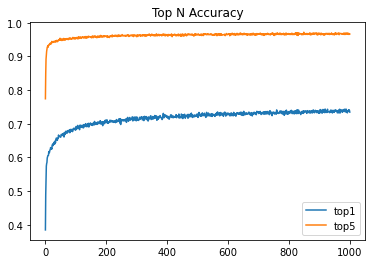

In [29]:
plt.plot(list(range(len(top_1_accs))), top_1_accs, label='top1')
plt.plot(list(range(len(top_5_accs))), top_5_accs, label='top5')
plt.legend()
plt.title('Top N Accuracy')
plt.savefig('top_n_24hr.png')
plt.show()

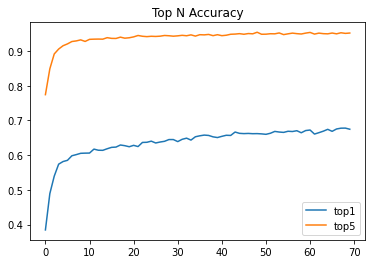

In [31]:
plt.plot(list(range(len(top_1_accs)))[:70], top_1_accs[:70], label='top1')
plt.plot(list(range(len(top_5_accs)))[:70], top_5_accs[:70], label='top5')
plt.legend()
plt.title('Top N Accuracy')
plt.savefig('top_n_24hr_70ep.png')
plt.show()

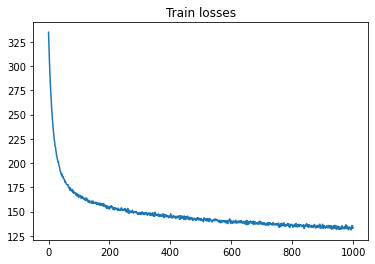

In [33]:
train_losses = np.asarray(train_losses)
plt.plot(list(range(len(train_losses))), train_losses)
# plt.plot(list(range(len(train_losses))), train_losses / len(train_dataset))
plt.title('Train losses')
plt.savefig('train_losses_24hr.png')

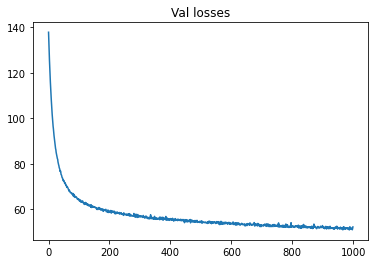

In [35]:
val_losses = np.asarray(val_losses)
plt.plot(list(range(len(val_losses))), val_losses)
# plt.plot(list(range(len(val_losses))), val_losses / len(val_dataset))
plt.title('Val losses')
plt.savefig('val_losses_24hr.png')

Save Trained Backbone

In [36]:
torch.save(backbone.state_dict(), 'FINAL_re-trained_backbone_24hr.pth')